# Final Code edition

In [1]:
#ssh -L 2222:apollo.lcn.ucl.ac.uk:22 jdupatel@galaxy.lcn.ucl.ac.uk
import numpy as np
import os
import tensorflow as tf
import keras
import cv2
from math import ceil, sqrt, floor

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm
from PIL import Image
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from scipy.ndimage import center_of_mass, label as nd_label, find_objects
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

from keras import regularizers, layers, models
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

from scipy.ndimage import gaussian_filter, center_of_mass

from scipy.stats import skew
from scipy.spatial.distance import cdist

import seaborn as sns
from kneed import KneeLocator

import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure

from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import mode

from collections import Counter

print("TensorFlow version:", tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs Available:", physical_devices)

tile_size=32

TensorFlow version: 2.15.0
GPUs Available: []


In [2]:
data_dir = "MSc2024_Data/jpg"

# Lists to store extracted data
image_list = []
image_data_list = []
type_list = []
month_list = []
day_list = []

# Going through the dataset
for dataset_type in ['train', 'test', 'predict']:  # High-level folders
    type_path = os.path.join(data_dir, dataset_type)
    if not os.path.isdir(type_path):
        continue
    
    if dataset_type == 'predict':
        # Predict folder contains only image files
        for file in os.listdir(type_path):
            if file.endswith('.jpg') and not file.startswith('._'):
                image_path = os.path.join(type_path, file)
                with Image.open(image_path) as img:
                    image_array = np.array(img)[:,:,0]/255.0
                
                image_list.append(image_array)
                image_data_list.append("No data")  # No metadata available
                type_list.append('Predict')
                month_list.append('N/A')
                day_list.append('N/A')
    
    else:
        # For train and test folders with month/day substructure
        for month_folder in os.listdir(type_path):  
            month_path = os.path.join(type_path, month_folder)
            if not os.path.isdir(month_path):
                continue
            
            for day_folder in os.listdir(month_path):  
                day_path = os.path.join(month_path, day_folder)
                if not os.path.isdir(day_path):
                    continue
                
                for file in os.listdir(day_path):
                    if file.endswith('.jpg') and not file.startswith('._'):
                        image_path = os.path.join(day_path, file)
                        txt_path = os.path.splitext(image_path)[0] + ".txt"

                        with Image.open(image_path) as img:
                            image_array = np.array(img)[:,:,0]/255.0
                        
                        if os.path.exists(txt_path):
                            with open(txt_path, 'r') as f:
                                image_metadata = f.read().strip()
                        else:
                            image_metadata = "No data"

                        month = month_folder.split('_')[-1]
                        day = int(day_folder.split('_')[-1])

                        image_list.append(image_array)
                        image_data_list.append(image_metadata)
                        type_list.append(dataset_type.capitalize())
                        month_list.append(month)
                        day_list.append(day)


# Create the structured DataFrame
data = pd.DataFrame({
    'Image': image_list,
    'Image data': image_data_list,
    'Type': type_list,
    'Month': month_list,
    'Day': day_list
})

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image       1774 non-null   object
 1   Image data  1774 non-null   object
 2   Type        1774 non-null   object
 3   Month       1774 non-null   object
 4   Day         1774 non-null   object
dtypes: object(5)
memory usage: 69.4+ KB
None


## Cropping images for training

In [4]:
def crop(image, pixels):
    """
    Crop an image to the closest multiple of pixel value for both width and height.

    :param image_path: Path to the input image.
    :param output_path: Path to save the cropped image.
    """
    # Open the image
    width, height = image.shape
    
    # Calculate the new dimensions (closest multiple less than or equal to the original size)
    new_width = (width // pixels) * pixels
    new_height = (height // pixels) * pixels
    
    # Calculate the cropping box (left, upper, right, lower)
    left = (width - new_width) // 2
    upper = (height - new_height) // 2
    right = left + new_width
    lower = upper + new_height
    
    # Crop the image
    cropped_img = image[left:right, upper:lower]
    
    # Save the cropped image
    return np.array(cropped_img)


def segmenter(img, tile_size):
    rows = int(img.shape[0]/tile_size)
    cols = int(img.shape[1]/tile_size)
    segments = []

    for i in range(0, img.shape[0], tile_size):
        for j in range(0, img.shape[1], tile_size):
            segment = img[i:i+tile_size, j:j+tile_size]
            segments.append(segment)
    return segments, rows, cols

tile_size = 32

cropped_train_images = []
cropped_test_images = []

for i in tqdm((data[data['Type'] == 'Train']['Image']), desc='Cropping training images'):
    img = crop(i , tile_size)
    cropped_train_images.append(img)
    
for i in tqdm((data[data['Type'] == 'Test']['Image']), desc='Cropping testing images'):
    img = crop(i , tile_size)
    cropped_test_images.append(img)


'''total_train_segments = sum((i.shape[0] // tile_size) * (i.shape[1] // tile_size) for i in cropped_train_images)
total_test_segments = sum((i.shape[0] // tile_size) * (i.shape[1] // tile_size) for i in cropped_test_images)

training = np.empty((total_train_segments, tile_size, tile_size))
testing = np.empty((total_test_segments, tile_size, tile_size))

ind = 0 
for i in tqdm(cropped_train_images, desc='Segmenting images'):
    segments = segmenter(i, tile_size)[0]
    for j in segments:
        training[ind] = np.array(j)
        ind+=1

ind = 0
for i in tqdm(cropped_test_images, desc='Segmenting images'):
    segments = segmenter(i, tile_size)[0]
    for j in segments:
        testing[ind] = np.array(j)
        ind+=1

# Shuffle
np.random.shuffle(training)
np.random.shuffle(testing)

print(training.shape, testing.shape)'''

Cropping testing images: 100%|██████████| 282/282 [00:15<00:00, 18.36it/s] 


"total_train_segments = sum((i.shape[0] // tile_size) * (i.shape[1] // tile_size) for i in cropped_train_images)\ntotal_test_segments = sum((i.shape[0] // tile_size) * (i.shape[1] // tile_size) for i in cropped_test_images)\n\ntraining = np.empty((total_train_segments, tile_size, tile_size))\ntesting = np.empty((total_test_segments, tile_size, tile_size))\n\nind = 0 \nfor i in tqdm(cropped_train_images, desc='Segmenting images'):\n    segments = segmenter(i, tile_size)[0]\n    for j in segments:\n        training[ind] = np.array(j)\n        ind+=1\n\nind = 0\nfor i in tqdm(cropped_test_images, desc='Segmenting images'):\n    segments = segmenter(i, tile_size)[0]\n    for j in segments:\n        testing[ind] = np.array(j)\n        ind+=1\n\n# Shuffle\nnp.random.shuffle(training)\nnp.random.shuffle(testing)\n\nprint(training.shape, testing.shape)"

## The Autoencoder

In [ ]:
latent_neurons = 128

# Autoencoder model
input_layer = keras.layers.Input(shape=(tile_size, tile_size, 1))

# Encoder layer 1
conv1 = keras.layers.Conv2D(
    128, 3, activation='relu', padding='same',
    kernel_regularizer=regularizers.l2(0.0001)
)(input_layer)
bn1 = keras.layers.BatchNormalization()(conv1)
act1 = keras.layers.Activation('relu')(bn1)
pool1 = keras.layers.MaxPooling2D(pool_size=2, padding='same')(act1)

# Encoder layer 2
conv2 = keras.layers.Conv2D(
    256, 3, activation='relu', padding='same',
    kernel_regularizer=regularizers.l2(0.0001)
)(pool1)
bn2 = keras.layers.BatchNormalization()(conv2)
act2 = keras.layers.Activation('relu')(bn2)
pool2 = keras.layers.MaxPooling2D(pool_size=2, padding='same')(act2)

# Layer 3
conv3 = keras.layers.Conv2D(
    512, 3, activation='relu', padding='same',
    kernel_regularizer=regularizers.l2(0.0001)
)(pool2)
bn3 = keras.layers.BatchNormalization()(conv3)
act3 = keras.layers.Activation('relu')(bn3)
pool3 = keras.layers.MaxPooling2D(pool_size=2, padding='same')(conv3)
pool3 = keras.layers.Dropout(0.2)(pool3)

# Dense section
flat = keras.layers.Flatten()(pool3)
latent = keras.layers.Dense(latent_neurons, activation='relu')(flat)

# Decoder
reshaping = keras.layers.Dense(4*4*512, activation='relu')(latent)
reshape = keras.layers.Reshape((4,4,512))(reshaping)

# Decoder layer 1
up1 = keras.layers.UpSampling2D(size=2)(reshape)
upconv1 = keras.layers.Conv2D(
    256, 3, activation="relu", padding='same',
    kernel_regularizer=regularizers.l2(0.0001)
)(up1)
bn4 = keras.layers.BatchNormalization()(upconv1)
act4 = keras.layers.Activation('relu')(bn4)
upconv1 = keras.layers.Dropout(0.2)(act4)

# Decoder layer 2
up2 = keras.layers.UpSampling2D(size=2)(upconv1)
upconv2 = keras.layers.Conv2D(
    128, 3,  activation="relu", padding='same',
    kernel_regularizer=regularizers.l2(0.0001)
)(up2)
bn5 = keras.layers.BatchNormalization()(upconv2)
act5 = keras.layers.Activation('relu')(bn5)

# Decoder layer 3
up3 = keras.layers.UpSampling2D(size=2)(act5)
upconv3 = keras.layers.Conv2D(1, 3,  activation="sigmoid", padding='same')(up3)


# Full model
autoencoder = keras.Model(inputs = input_layer, outputs=upconv3)

optimiser = keras.optimizers.Adam(learning_rate=0.001)

autoencoder.compile(loss = 'mean_squared_error', optimizer = optimiser)
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8, verbose=1)

modelhistory = autoencoder.fit(
    training, training,
    batch_size = 128,
    epochs=150,
    validation_data=(testing, testing),
    verbose=2,
    callbacks=[early_stopping, reduce_lr]
)


print(f'Training loss {latent_neurons}: ',modelhistory.history['loss'][-1])
print(f'Validation loss {latent_neurons}: ', modelhistory.history['val_loss'][-1])

autoencoder.save(f'32in{latent_neurons}latentdensefinalv2.keras')

plt.plot(modelhistory.history['loss'], label='Training')
plt.plot(modelhistory.history['val_loss'], label='Testing')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training loss and Validation loss. {latent_neurons} latent neurons')
plt.savefig(f'32in{latent_neurons}traininghistorydensefinalv2.png')
plt.clf()

## Loading trained models in

In [3]:
#model16 = keras.models.load_model('Densemodel/finaltest/16neuronAE.keras')


# For some reason HPC cluster got updated between regule model and the new model so 
#.h5 and .keras for defectmodel

model = keras.models.load_model('Densemodel/finaltest/32neuronAE.h5')
defectmodel = keras.models.load_model('Densemodel/finaltest/defect_autoencoder_8latent.keras')

'''model16 = keras.models.load_model('Densemodel/finaltest/16neuronAE.h5')
model64 = keras.models.load_model('Densemodel/finaltest/64neuronAE.h5')
model128 = keras.models.load_model('Densemodel/finaltest/128neuronAE.h5')
model256 = keras.models.load_model('Densemodel/finaltest/256neuronAE.h5')'''

model.summary()
defectmodel.summary()

# Extract the encoder and decoder from the full trained model

encoder_split = keras.Model(inputs=model.input, outputs=model.get_layer('dense').output)

decoder_split = keras.Model(inputs=model.get_layer('dense').output, outputs=model.output)


def_encoder_split = keras.Model(inputs=defectmodel.input, outputs=defectmodel.get_layer('dense_1').output)

def_decoder_split = keras.Model(inputs=defectmodel.get_layer('dense_1').output, outputs=defectmodel.output)
#encoder256_split = keras.Model(inputs=model256.input, outputs=model256.get_layer('dense').output)

#decoder256_split = keras.Model(inputs=model256.get_layer('dense').output, outputs=model256.output)

#decoder_split.summary()
print('Models loaded')

c:\Users\jaydi\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │       270,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,488,291 (13.31 MB)

 Trainable params: 3,486,753 (13.30 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 2 (12.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8192)           │     2,105,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 17,012,253 (64.90 MB)

 Trainable params: 5,670,153 (21.63 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 11,340,308 (43.26 MB)

Models loaded


In [6]:
training  = np.load('training.npy')

In [7]:
'''defect_patches = np.load('Densemodel/finaltest/defect_patches_final.npy')
print('Defects loaded')

latent_patches = encoder_split.predict(training)
latent_defects = encoder_split.predict(defect_patches)
print('Latent generated')'''

"defect_patches = np.load('Densemodel/finaltest/defect_patches_final.npy')\nprint('Defects loaded')\n\nlatent_patches = encoder_split.predict(training)\nlatent_defects = encoder_split.predict(defect_patches)\nprint('Latent generated')"

In [2]:
latent_patches  = np.load('latent_patches.npy')
np.random.shuffle(latent_patches)
#print(training.shape)
print(latent_patches.shape)

scaler = MinMaxScaler()
scaler.fit_transform(latent_patches)

latent_patches_s = scaler.transform(latent_patches)

print('scaled')
print(latent_patches_s[0].shape)

(315946, 32)
scaled
(32,)


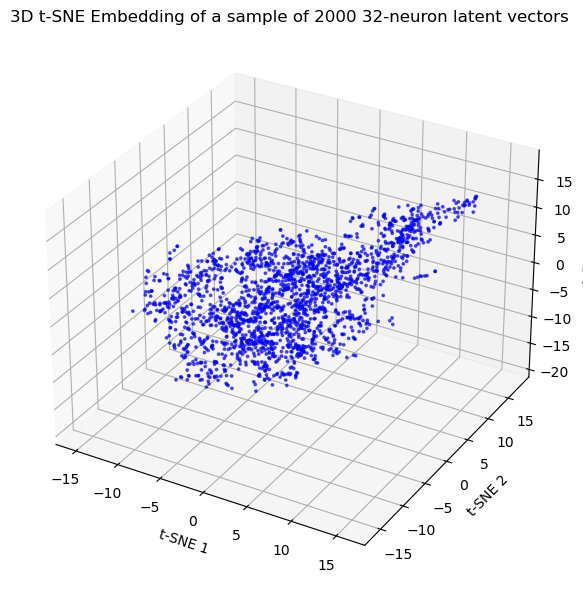

In [ ]:
from sklearn.manifold import TSNE

# Sample a subset to make t-SNE computationally feasible
np.random.seed(42)
sample_indices = np.random.choice(latent_patches_s.shape[0], size=2000, replace=False)
sampled_vectors = latent_patches_s[sample_indices]

# Run t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=2000, init='random', random_state=42)
embedded = tsne.fit_transform(sampled_vectors)

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded[:, 0], embedded[:, 1], embedded[:, 2],
           c='blue', s=3, alpha=0.6)

ax.set_title('3D t-SNE Embedding of a sample of 2000 32-neuron latent vectors')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.tight_layout()
plt.show()

In [ ]:
def plot_segments(img, tile_size=32):
    """
    Plot image segments in a grid without gaps.

    Parameters:
        img (np.array): Input image.
        tile_size (int): Size of each segment (assumes square tiles).
    """
    img = np.array(img)
    segments, rows, cols = segmenter(img, tile_size)
    print(img.shape, rows, cols)

    fig, axes = plt.subplots(rows, cols, figsize=(rows/3, cols/3))
    
    for i, ax in enumerate(axes.flat):
        if i < len(segments):
            ax.imshow(segments[i], vmin=0, vmax=1)
            ax.set_xticks([])  # Remove x ticks
            ax.set_yticks([])  # Remove y ticks
            ax.set_frame_on(False)  # Remove the frame
        else:
            ax.axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)  # No padding
    plt.margins(0, 0)  # No margins
    plt.tight_layout(pad=0)  # Tight layout with no padding
    plt.show()

def plot_postsegments(segments, grid_size):
    """
    Plots segements of an image as a grid.

    Inputs:
        segments: Image segments
        tile_size: Size of each square segment
        grid_size: Grid size (rows, cols)
    Outputs:
        plot: The plot

    """
    rows, cols = grid_size
    print(rows, cols)

    fig, axes = plt.subplots(rows, cols, figsize=(rows/3, cols/3))
    
    for i, ax in enumerate(axes.flat):
        if i < len(segments):
            ax.imshow(segments[i], vmin=0, vmax=1)
            ax.set_xticks([])  # Remove x ticks
            ax.set_yticks([])  # Remove y ticks
            ax.set_frame_on(False)
        else:
            ax.axis('off')  # Hide empty subplots

    plt.subplots_adjust(wspace=0, hspace=0)  # No padding
    plt.margins(0, 0)  # No margins
    plt.tight_layout(pad=0)  # Tight layout with no padding
    plt.show()
    return
    
'''test_image = cropped_test_images[np.random.randint(0, len(cropped_test_images))]
test_segments = segmenter(test_image, tile_size)[0]

plot_segments(test_image, 32)

#test_ae = model.predict(np.array(test_segments))
test_scale = decoder_split.predict(scaler.inverse_transform(scaler.transform(encoder_split(np.array(test_segments)))))
test_scale_16 = model16.predict(np.array(test_segments))
test_scale_64 = model64.predict(np.array(test_segments))
test_scale_128 = model128.predict(np.array(test_segments))
test_scale_256 = model256.predict(np.array(test_segments))

dimx, dimy = int(test_image.shape[0]/32), int(test_image.shape[1]/32)
#plot_postsegments(test_ae[0:(dimx*dimy)], (dimx, dimy))
plot_postsegments(test_scale[0:(dimx*dimy)], (dimx, dimy))

plot_postsegments(test_scale_16[0:(dimx*dimy)], (dimx, dimy))
plot_postsegments(test_scale_64[0:(dimx*dimy)], (dimx, dimy))
plot_postsegments(test_scale_128[0:(dimx*dimy)], (dimx, dimy))
plot_postsegments(test_scale_256[0:(dimx*dimy)], (dimx, dimy))


test_def_img = training[np.random.randint(0,len(training))]
test_def = def_decoder_split.predict(def_encoder_split(test_def_img.reshape(1,32,32,1)))

plt.imshow(test_def_img)
plt.show()
plt.imshow(test_def.reshape(32,32))'''

## Kmeans + elbow method

100%|██████████| 18/18 [06:02<00:00, 20.12s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


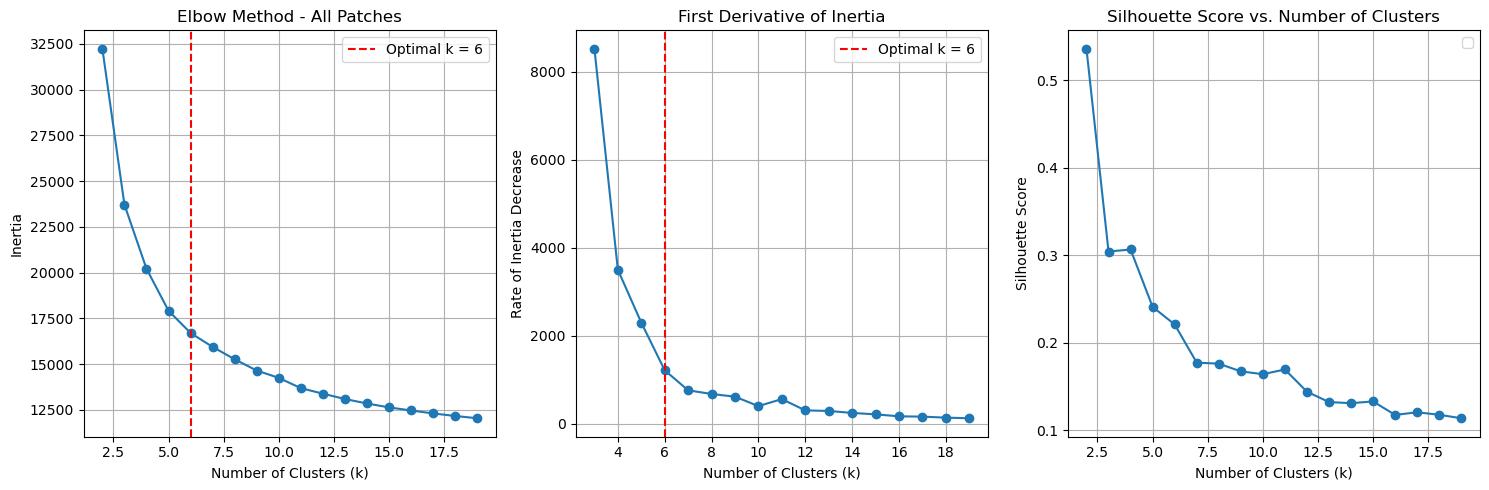

In [ ]:
from sklearn.metrics import silhouette_score

k_values = range(2, 20)

inertia_values_all = []
silhouette_scores_all = []

# Run K-means for different cluster numbers
for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=27, n_init=10)
    klabels = kmeans.fit_predict(latent_patches_s)
    inertia_values_all.append(kmeans.inertia_)
    silhouette_scores_all.append(silhouette_score(latent_patches_s[0:10000], klabels[0:10000]))

inertia_diff_all = np.diff(inertia_values_all)

# Elbow method using KneeLocator
knee_all = KneeLocator(k_values, inertia_values_all, curve="convex", direction="decreasing")
optimal_k_all = knee_all.knee

# Plotting
plt.figure(figsize=(15, 5))

# Plot 1: Elbow method (Inertia)
plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values_all, marker='o', linestyle='-')
plt.axvline(x=optimal_k_all, color='red', linestyle='--', label=f'Optimal k = {optimal_k_all}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method - All Patches")
plt.legend()
plt.grid(True)

# Plot 2: First Derivative of Inertia
plt.subplot(1, 3, 2)
plt.plot(k_values[1:], -inertia_diff_all, marker='o', linestyle='-')
plt.axvline(x=optimal_k_all, color='red', linestyle='--', label=f'Optimal k = {optimal_k_all}')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Rate of Inertia Decrease")
plt.title("First Derivative of Inertia")
plt.legend()
plt.grid(True)

# Plot 3: Silhouette Score
plt.subplot(1, 3, 3)
plt.plot(k_values, silhouette_scores_all, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
# optimalk_all = 6
kmeansall = KMeans(n_clusters=7, random_state=27, n_init=10)
kmeanslabels = kmeansall.fit_predict(latent_patches_s)

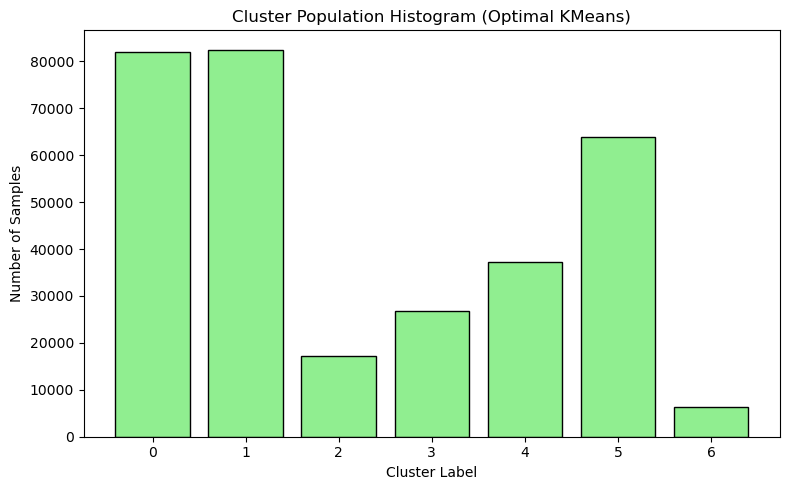

In [5]:
unique_labels, counts = np.unique(kmeanslabels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([str(int(lbl)) for lbl in unique_labels], counts, color='lightgreen', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Cluster Population Histogram (Optimal KMeans)')
plt.tight_layout()
plt.show()

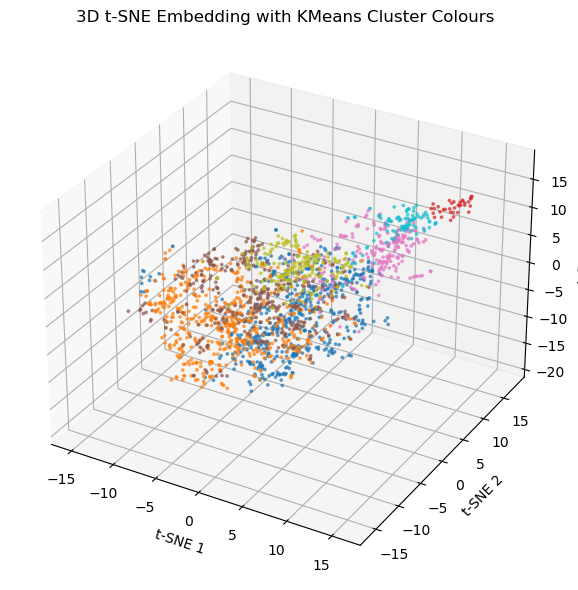

In [14]:
# Sample a subset to make t-SNE computationally feasible
np.random.seed(42)
sample_indices = np.random.choice(latent_patches_s.shape[0], size=2000, replace=False)
sampled_vectors = latent_patches_s[sample_indices]

# Get corresponding cluster labels for the sampled vectors
sampled_labels = kmeanslabels[sample_indices]

# Run t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=2000, init='random', random_state=42)
embedded = tsne.fit_transform(sampled_vectors)

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedded[:, 0], embedded[:, 1], embedded[:, 2],
                     c=sampled_labels, cmap='tab10', s=3, alpha=0.6)

ax.set_title('3D t-SNE Embedding with KMeans Cluster Colours')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

plt.tight_layout()
plt.show()

Tuning eps: 100%|██████████| 20/20 [04:19<00:00, 12.97s/it]


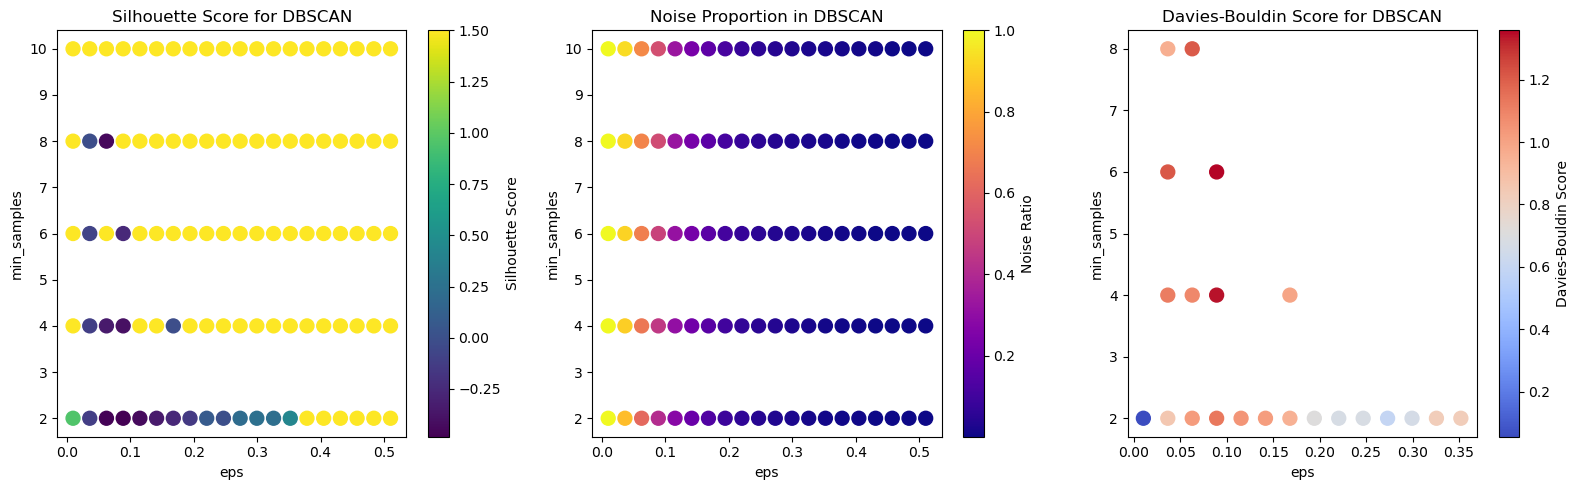

Best parameters: eps = 0.29947368421052634, min_samples = 2.0


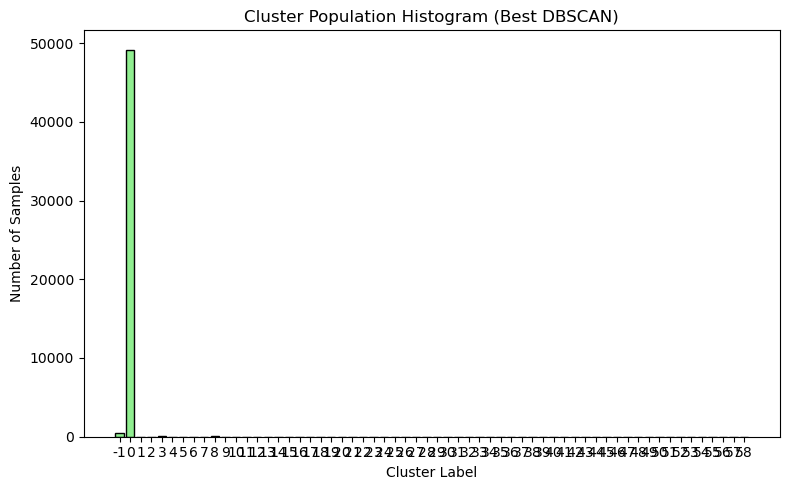

In [ ]:
# Parameter grids
eps_range = np.linspace(0.01, 0.51, 20)
min_samples_range = range(2, 12, 2)

# Store metrics
silhouette_scores = []
db_scores = []
noise_ratios = []
test_sample = latent_patches_s[0:10000]
# Grid search over parameters
for eps in tqdm(eps_range, desc="Tuning eps"):
    for min_samples in tqdm(min_samples_range):
        dbscan = None
        labels = None
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = dbscan.fit_predict(test_sample)
        
        # Exclude noise points
        core_samples_mask = (labels != -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)
        
        # Compute clustering metrics if there are at least 2 clusters
        if n_clusters > 7:
            sil_score = silhouette_score(test_sample[core_samples_mask], labels[core_samples_mask])
            db_score = davies_bouldin_score(test_sample[core_samples_mask], labels[core_samples_mask])
        else:
            sil_score = 1.5  # Invalid silhouette if only 1 cluster
            db_score = np.inf  # Invalid DB score if only 1 cluster
        
        # Store
        silhouette_scores.append((eps, min_samples, sil_score))
        db_scores.append((eps, min_samples, db_score))
        noise_ratios.append((eps, min_samples, noise_ratio))

# Convert to numpy arrays for easier handling
silhouette_array = np.array(silhouette_scores)
db_array = np.array(db_scores)
noise_array = np.array(noise_ratios)

# Plot Silhouette scores
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.scatter(silhouette_array[:, 0], silhouette_array[:, 1], c=silhouette_array[:, 2], cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Silhouette Score for DBSCAN')

# Plot Noise Ratios
plt.subplot(1, 3, 2)
plt.scatter(noise_array[:, 0], noise_array[:, 1], c=noise_array[:, 2], cmap='plasma', s=100)
plt.colorbar(label='Noise Ratio')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Noise Proportion in DBSCAN')

import matplotlib.pyplot as plt
import numpy as np

plt.subplot(1, 3, 3)
plt.scatter(db_array[:, 0], db_array[:, 1], c=db_array[:, 2], cmap='coolwarm', s=100)
plt.colorbar(label='Davies-Bouldin Score')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Davies-Bouldin Score for DBSCAN')
plt.tight_layout()
plt.show()

# Step 1: Filter valid results
valid_mask = (silhouette_array[:, 2] < 1.5) & (db_array[:, 2] != np.inf)
valid_sil = silhouette_array[valid_mask]
valid_db = db_array[valid_mask]
valid_noise = noise_array[valid_mask]

# Step 2: Normalise (optional)
# Flip silhouette so higher is better => lower rank is better
sil_norm = -valid_sil[:, 2]
db_norm = valid_db[:, 2]
noise_norm = valid_noise[:, 2]

# Step 3: Rank
sil_rank = sil_norm.argsort().argsort()
db_rank = db_norm.argsort().argsort()
noise_rank = noise_norm.argsort().argsort()

# Step 4: Aggregate rank (equal weight)
total_rank = sil_rank + db_rank + noise_rank
best_idx = np.argmin(total_rank)

# Step 5: Retrieve best parameters
best_eps, best_min_samples = valid_sil[best_idx, 0], valid_sil[best_idx, 1]
print(f"Best parameters: eps = {best_eps}, min_samples = {best_min_samples}")

final_dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples), metric='euclidean')
final_labels = final_dbscan.fit_predict(latent_patches_s[0:50000])

# Plot cluster histogram
unique_labels, counts = np.unique(final_labels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([str(int(lbl)) for lbl in unique_labels], counts, color='lightgreen', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Cluster Population Histogram (Best DBSCAN)')
plt.tight_layout()
plt.show()

Tuning min_cluster_size:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_cluster_size: 100%|██████████| 10/10 [02:58<00:00, 17.86s/it]


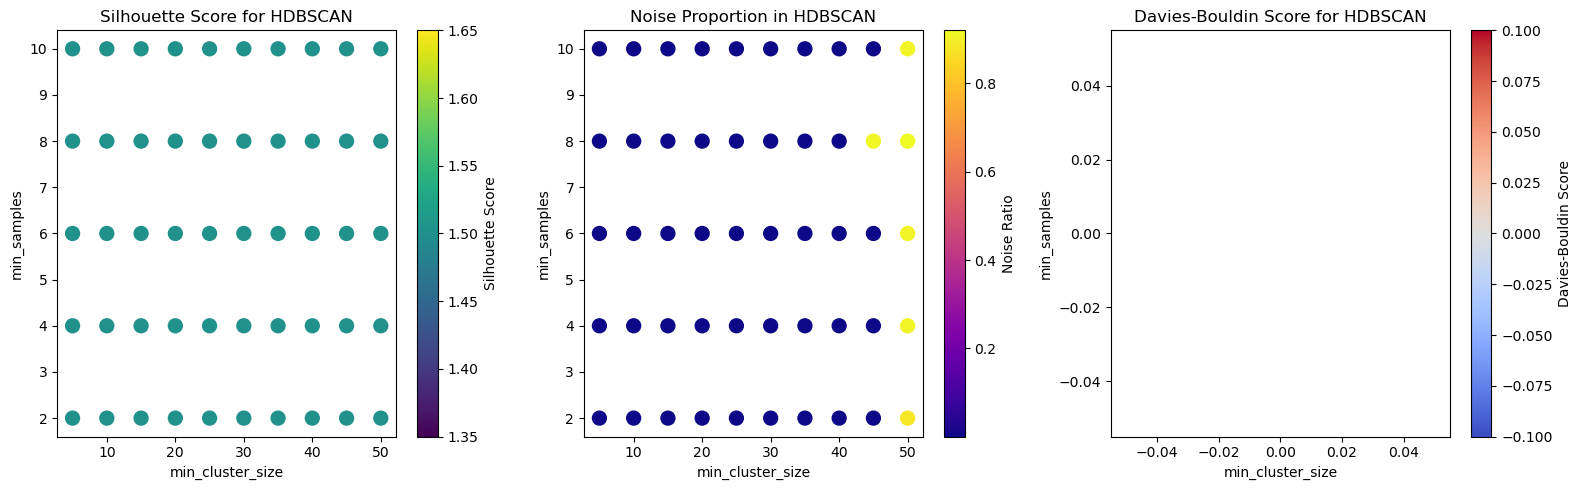

ValueError: attempt to get argmin of an empty sequence

In [15]:
# Define parameter grids
min_cluster_sizes = range(5, 51, 5)
min_samples_range = range(2, 12, 2)

# Store metrics
silhouette_scores = []
db_scores = []
noise_ratios = []

test_sample = latent_patches_s[0:10000]

# Grid search over HDBSCAN parameters
for min_cluster_size in tqdm(min_cluster_sizes, desc="Tuning min_cluster_size"):
    for min_samples in min_samples_range:
        clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                    min_samples=min_samples,
                                    metric='euclidean')
        labels = clusterer.fit_predict(test_sample)

        core_samples_mask = (labels != -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)

        if n_clusters > 7:
            sil_score = silhouette_score(test_sample[core_samples_mask], labels[core_samples_mask])
            db_score = davies_bouldin_score(test_sample[core_samples_mask], labels[core_samples_mask])
        else:
            sil_score = 1.5
            db_score = np.inf

        silhouette_scores.append((min_cluster_size, min_samples, sil_score))
        db_scores.append((min_cluster_size, min_samples, db_score))
        noise_ratios.append((min_cluster_size, min_samples, noise_ratio))

# Convert to arrays
silhouette_array = np.array(silhouette_scores)
db_array = np.array(db_scores)
noise_array = np.array(noise_ratios)

# Plot metrics
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.scatter(silhouette_array[:, 0], silhouette_array[:, 1], c=silhouette_array[:, 2], cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('min_cluster_size')
plt.ylabel('min_samples')
plt.title('Silhouette Score for HDBSCAN')

plt.subplot(1, 3, 2)
plt.scatter(noise_array[:, 0], noise_array[:, 1], c=noise_array[:, 2], cmap='plasma', s=100)
plt.colorbar(label='Noise Ratio')
plt.xlabel('min_cluster_size')
plt.ylabel('min_samples')
plt.title('Noise Proportion in HDBSCAN')

plt.subplot(1, 3, 3)
plt.scatter(db_array[:, 0], db_array[:, 1], c=db_array[:, 2], cmap='coolwarm', s=100)
plt.colorbar(label='Davies-Bouldin Score')
plt.xlabel('min_cluster_size')
plt.ylabel('min_samples')
plt.title('Davies-Bouldin Score for HDBSCAN')

plt.tight_layout()
plt.show()

# Select best parameters based on combined metric
valid_mask = (silhouette_array[:, 2] < 1.5) & (db_array[:, 2] != np.inf)
valid_sil = silhouette_array[valid_mask]
valid_db = db_array[valid_mask]
valid_noise = noise_array[valid_mask]

sil_norm = -valid_sil[:, 2]
db_norm = valid_db[:, 2]
noise_norm = valid_noise[:, 2]

sil_rank = sil_norm.argsort().argsort()
db_rank = db_norm.argsort().argsort()
noise_rank = noise_norm.argsort().argsort()

total_rank = sil_rank + db_rank + noise_rank
best_idx = np.argmin(total_rank)

best_min_cluster_size = int(valid_sil[best_idx, 0])
best_min_samples = int(valid_sil[best_idx, 1])
print(f"Best HDBSCAN parameters: min_cluster_size = {best_min_cluster_size}, min_samples = {best_min_samples}")

# Final clustering on larger sample
final_clusterer = hdbscan.HDBSCAN(min_cluster_size=best_min_cluster_size,
                                  min_samples=best_min_samples,
                                  metric='euclidean')
final_labels = final_clusterer.fit_predict(latent_patches_s[0:50000])

# Plot histogram of final cluster populations
unique_labels, counts = np.unique(final_labels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([str(int(lbl)) for lbl in unique_labels], counts, color='lightgreen', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Cluster Population Histogram (Best HDBSCAN)')
plt.tight_layout()
plt.show()

## Basically the start

In [48]:
def sliding_window(image, window_size, stride):
    h, w, = image.shape
    patches = []
    positions = []
    for i in range(0, h - window_size + 1, stride):
        for j in range(0, w - window_size + 1, stride):
            patch = image[i:i + window_size, j:j + window_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions

def mode_image(image, encoder, cluster_model, scaler, window_size=tile_size, stride=2):
    patches, positions = sliding_window(image, window_size, stride)

    # Get latent vectors for all patches
    latent_vector_patch = [encoder(patch.reshape(1, window_size, window_size, 1)).numpy().flatten()
                           for patch in tqdm(patches)]
    latent_flattened = np.array(latent_vector_patch)


    latent_flattened = scaler.transform(latent_flattened)

    # Clustering
    cluster_ids = cluster_model.fit_predict(latent_flattened)

    # Initialize character map and vote storage
    char_map = np.full(image.shape[:2], -1, dtype=int)  # Initialize as -1 (unassigned)
    vote_dict = {}  # Stores votes for each pixel location

    for (i, j), cluster_id in zip(positions, cluster_ids):
        if cluster_id == -1:
            continue  # Ignore noise
        for x in range(i, i + window_size):
            for y in range(j, j + window_size):
                if 0 <= x < image.shape[0] and 0 <= y < image.shape[1]:  # Ensure within bounds
                    if (x, y) not in vote_dict:
                        vote_dict[(x, y)] = []
                    vote_dict[(x, y)].append(cluster_id)

    # Apply majority voting per pixel
    for (x, y), votes in vote_dict.items():
        char_map[x, y] = Counter(votes).most_common(1)[0][0]  # Most common cluster ID

    return char_map

def find_medoids(latent_vectors_train, labels, sample_size=100):
    unique_labels = np.unique(labels)
    medoids = []

    for label in tqdm(unique_labels):
        # Get points belonging to the current cluster
        cluster_points = latent_vectors_train[labels == label]
        n_points = len(cluster_points)

        # Reduce computations for large clusters by sampling
        if n_points > sample_size:
            sampled_indices = np.random.choice(n_points, size=sample_size, replace=False)
            cluster_points = cluster_points[sampled_indices]

        # Compute pairwise distances within the sampled cluster
        distances = pairwise_distances(cluster_points)

        # Find the medoid (point with the smallest sum of distances)
        medoid_index = np.argmin(distances.sum(axis=0))
        medoids.append(cluster_points[medoid_index])

    return np.array(medoids)

def compareimage_choose(original, char, selected_group=None):
    """
    Static matplotlib visualization with optional selection of a specific cluster/group in char map.
    
    Parameters:
    -----------
    og : np.array
        Original STM image.
    char : np.array
        Character map (clusters).
    selected_group : int or None
        If provided, only this group will be shown in the character map.
    """
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), dpi=500)

    # First image: Original
    ax[0].imshow(original, origin='upper', cmap='viridis')
    ax[0].set_title('Original Image')
    
    ax[1].imshow(char, cmap='RdBu')
    ax[1].set_title('Character Map')

    # Second image: Character map (filtered if group selected)
    if selected_group is not None:
        char_filtered = np.where(char == selected_group, char, np.nan)  # Set non-selected groups to NaN
        ax[2].imshow(original, cmap='viridis')
        color = ax[2].imshow(char_filtered, cmap='RdBu', origin='upper', vmin=np.nanmin(char), vmax=np.nanmax(char))
        ax[2].set_title(f'Character map (Group {selected_group})')
    else:
        color = ax[2].imshow(char, cmap='RdBu', origin='upper')
        ax[2].set_title('Character map (All groups)')

    fig.colorbar(color, ax=ax[1], orientation='vertical', fraction=0.05)

    # Third image: Overlay
    im = ax[3].imshow(original, origin='upper', cmap='viridis')
    im_overlay = ax[3].imshow(char, alpha=0.4, cmap='RdBu', origin='upper')
    fig.colorbar(im_overlay, ax=ax[3], orientation='vertical', fraction=0.05)
    ax[3].set_title('Overlay')

    for axs in ax:
        axs.axis('off')

    plt.show()

def interactive_compareimage(og, char):
    unique_groups = np.unique(char[char != -1])  # Exclude noise if needed
    
    def update(selected_group):
        compareimage_choose(og, char, selected_group)
    
    interact(update, selected_group=[None] + list(unique_groups))  # Add None for all groups

def extract_high_error_patches(original_image, model, tile_size=32, stride=8, min_dist=10, plot_maps=False, plot_defects=False):
    """
    Identifies high-error regions and extracts 32x32 patches, ensuring minimal redundancy.
    
    Inputs:
        original_image: Full STM image (2D numpy array).
        model: Autoencoder model for reconstruction error.
        tile_size: Size of extracted patches (default: 32x32).
        stride: Step size for scanning.
        min_dist: Minimum allowed distance between defect centers.
    
    Outputs:
        Extracted defect patches and visualization.
    """
    h, w = original_image.shape
    half_tile = tile_size // 2

    error_map = np.zeros((h, w))  # Initialize error map
    count_map = np.zeros((h, w))  # Track how many times each pixel is covered

    # Step 1: Compute reconstruction error map
    for y in tqdm(range(0, h, stride)):
        for x in range(0, w, stride):
            y1, y2 = min(y, h - tile_size), min(y + tile_size, h)
            x1, x2 = min(x, w - tile_size), min(x + tile_size, w)

            patch = original_image[y1:y2, x1:x2]
            if patch.shape != (tile_size, tile_size):
                patch = cv2.copyMakeBorder(patch, 0, tile_size - patch.shape[0], 0, tile_size - patch.shape[1], borderType=cv2.BORDER_REFLECT)

            patch_input = patch.reshape(1, tile_size, tile_size, 1)
            reconstructed_patch = model.predict(patch_input, verbose=0)[0].reshape(tile_size, tile_size)

            error_patch = np.abs(patch - reconstructed_patch) ** 2

            error_map[y1:y2, x1:x2] += error_patch
            count_map[y1:y2, x1:x2] += 1

        
    count_map[count_map == 0] = 1  # Avoid division by zero
    error_map /= count_map  # Normalize error map
    raw_map = error_map

    # Step 2: Compute threshold dynamically
    sigma = max(2, np.std(error_map) / 5)
    error_map = gaussian_filter(error_map, sigma=sigma)  # Apply Gaussian smoothing

    error_skewness = skew(raw_map.flatten())
    threshold_percentile = 97 + 2 * min(1, error_skewness)  # Between 97% and 99%

    threshold = np.percentile(error_map, threshold_percentile)  # Adjust percentile dynamically
    
    high_error_ratio = np.sum(error_map > threshold) / error_map.size
    print(high_error_ratio)
    if high_error_ratio > 0.2:  # If more than 50% of pixels exceed the threshold
        error_map = np.max(error_map) - error_map  # Flip the error map
        print("Error map flipped due to high error coverage.")
    defect_mask = (error_map > threshold).astype(np.uint8)

    # Step 3: Extract defect regions using scipy.ndimage.label for connected components
    labeled_mask = nd_label(defect_mask)[0]
    num_labels = np.max(labeled_mask)
    defect_patches = []
    centers = []  # Store (x, y) positions of defect centers
    error_values = []  # Store corresponding error values

    # Get the centroids using center_of_mass
    for label_idx in range(1, num_labels + 1):
        region_mask = (labeled_mask == label_idx)  # Mask for each region
        y, x = center_of_mass(region_mask)  # Get the centroid of the region
        if y<half_tile:
            y=half_tile
        if y>h-half_tile:
            y=h-half_tile-1
        if x<half_tile:
            x=half_tile
        if x>w-half_tile:
            x=w-half_tile-1
        if np.isnan(y) or np.isnan(x):
            continue

        y, x = int(round(y)), int(round(x))  # Round to nearest integer
        
        # Ensure the patch stays within bounds
        y1, y2 = max(0, y - half_tile), min(h, y + half_tile)
        x1, x2 = max(0, x - half_tile), min(w, x + half_tile)
        
        patch = original_image[y1:y2, x1:x2]

        # Ensure patch is exactly 32x32 (pad if needed)
        if patch.shape != (tile_size, tile_size):
            patch = cv2.copyMakeBorder(patch, 
                                       top=max(0, half_tile - y), bottom=max(0, y + half_tile - h),
                                       left=max(0, half_tile - x), right=max(0, x + half_tile - w),
                                       borderType=cv2.BORDER_CONSTANT, value=0)

        defect_patches.append(patch)
        centers.append((x, y))
        error_values.append(error_map[y, x])

    # Step 4: **Filter patches using Non-Maximum Suppression (NMS)**
    if min_dist > 0:
        filtered_centers, filtered_patches = [], []
        error_values = np.array(error_values)

        # Sort defects by error intensity (highest first)
        sorted_indices = np.argsort(-error_values)  
        selected = np.zeros(len(centers), dtype=bool)

        for i in sorted_indices:
            if selected[i]:  # Skip if already selected
                continue

            x1, y1 = centers[i]
            filtered_centers.append((x1, y1))
            filtered_patches.append(defect_patches[i])
            selected[i] = True

            # Remove nearby detections
            distances = np.linalg.norm(np.array(centers) - np.array([x1, y1]), axis=1)
            selected[distances < min_dist] = True  # Suppress nearby detections

        centers, defect_patches = filtered_centers, filtered_patches  # Update lists

    # Step 5: **Visualizations**
    if plot_maps==True:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
        
        axs[0].imshow(original_image, cmap='viridis')
        axs[0].set_title('Original STM Image')

        axs[1].imshow(error_map, cmap='hot')
        axs[1].set_title(f'Error Map (Threshold: {threshold_percentile:.2f})')

        axs[2].imshow(original_image, cmap='viridis')
        axs[2].set_title('Detected Defects')
        
        for x, y in centers:
            axs[1].scatter(x, y, color='green', marker='x', lw=1, s=10)
            axs[2].scatter(x, y, color='black', marker='x', lw=1, s=10)
        
        for ax in axs:
            ax.axis('off')
        
        plt.show()

    # Step 6: **Plot defect patches in a grid**
    if plot_defects==True:
        num_patches = len(defect_patches)
        grid_size = ceil(sqrt(num_patches))  # Find nearest square root

        fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        axs = axs.flatten()
        for i, patch in enumerate(defect_patches):
            axs[i].imshow(patch, cmap='viridis')
            axs[i].axis('off')
            axs[i].set_title(f'Defect {i+1}')

        # Hide unused subplots
        for j in range(i+1, len(axs)):
            axs[j].axis('off')

    return error_map, defect_patches, centers

def cluster_and_overlay(defect_patches, defect_centers, original_image, encoder, clusterer, tile_size=32, plot_defects=False):
    """
    Clusters defect patches using pre-trained encoder and KMeans, then overlays the clusters
    onto the original image.

    Inputs:
        defect_patches: List of 32x32 defect patches.
        defect_centers: List of (x, y) positions of defects.
        original_image: The original STM image.
        encoder: Pre-trained encoder model (used for feature extraction).
        kmeans: Pre-trained KMeans model for clustering.
        tile_size: Size of the defect patches (default 32).

    Outputs:
        Clustered defect visualization with overlay on the original image.
    """
    # Step 1: Extract features from defect patches using the encoder
    defect_features = encoder.predict(np.array(defect_patches))  # Use encoder to generate features
    defect_features = scaler.transform(defect_features)
        
    # Step 2: Perform clustering using the pre-trained KMeans model
    cluster_labels = clusterer.fit_predict(defect_features)

    # Step 3: Overlay cluster results onto the original image
    plt.figure(figsize=(8, 8), dpi=100)
    plt.imshow(original_image, cmap='viridis')
    ax = plt.gca()
    
    for (x, y), cluster in zip(defect_centers, cluster_labels):
        rect = patches.Rectangle((x - 16, y - 16), 32, 32, linewidth=1.5, edgecolor='k', facecolor='none')
        ax.add_patch(rect)
        plt.text(x + 10, y + 10, str(cluster), color='k', fontsize=10, ha='center', va='center')


    plt.title("Clustered Defects Overlay on STM Image")
    plt.axis('off')
    plt.show()

    if plot_defects==True:
        # Sort patches by cluster label
        sorted_indices = np.argsort(cluster_labels)
        sorted_patches = [defect_patches[i] for i in sorted_indices]
        sorted_labels = [cluster_labels[i] for i in sorted_indices]

        num_patches = len(defect_patches)
        grid_size = ceil(sqrt(num_patches))  # Find nearest square root

        if len(defect_patches)>1:
            fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
            axs = axs.flatten()

            for i, (patch, label) in enumerate(zip(sorted_patches, sorted_labels)):
                axs[i].imshow(patch, cmap='viridis', vmin=0, vmax=1)
                axs[i].axis('off')
                axs[i].set_title(f'Group {label}')

            # Hide unused subplots
            for j in range(i + 1, len(axs)):
                axs[j].axis('off')

            plt.tight_layout()
            plt.show()
        else:
            plt.imshow(np.array(defect_patches).reshape(32,32))
            plt.title(f'Group {cluster_labels}')
            plt.show()

    return cluster_labels

def generate_fine_characterization_mask(original_image, char_map, error_map, target_clusters, error_percentile=90, plot_mask=False):
    """
    Generates a binary mask highlighting areas for fine characterization based on:
    - Regions belonging to specific clusters in the characterization map.
    - Regions with high reconstruction error in the error map.

    Parameters:
        original_image (np.array): The original STM image.
        char_map (np.array): The coarse characterization map.
        error_map (np.array): The reconstruction error map.
        target_clusters (list): List of cluster labels to include.
        error_percentile (float): Percentile threshold for error map (default: 95).
        sigma (float): Gaussian smoothing parameter for the error map (default: 3).
        plot_mask (bool): Whether to plot the resulting mask.

    Returns:
        np.array: Binary mask (same shape as original image) highlighting areas for fine characterization.
    """
    h, w = original_image.shape
    
    # Step 1: Identify high-error regions
    error_threshold = np.percentile(error_map, error_percentile)
    high_error_mask = error_map > error_threshold
    
    # Step 2: Identify regions belonging to target clusters
    cluster_mask = np.isin(char_map, target_clusters)
    
    # Step 3: Combine masks (logical OR)
    fine_characterization_mask = (high_error_mask | cluster_mask).astype(np.uint8)
    
    # Step 4: Visualization (optional)
    if plot_mask==True:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(original_image)
        char = plt.imshow(char_map, cmap='RdBu', alpha=0.8)
        plt.colorbar(cmap=char)
        plt.title('Characterization Map')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(error_map, cmap='hot')
        plt.title('Error Map')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(original_image)
        mask = plt.imshow(fine_characterization_mask, cmap='Reds', alpha=0.5)
        plt.colorbar(cmap=mask)
        plt.title('Fine Characterization Mask')
        plt.axis('off')
        plt.show()
    
    return np.array(fine_characterization_mask)

def extract_masked_patches_and_cluster(original_image, fine_mask, encoder, clusterer, scaler, tile_size=32, min_dist=16, 
                                       plot_overlay=True, plot_defects=True):
    """
    Extracts and clusters defect patches based on a fine characterization mask using encoder + clustering model.
    Adds defect centers from the high_error_centers list to the clustering and patch extraction process.
    """
    h, w = original_image.shape
    half_tile = tile_size // 2

    labeled_mask, num_labels = nd_label(fine_mask)
    print(f"Number of regions detected: {num_labels}")

    defect_patches = []
    centers = []

    # Step 1: Iterate over each labeled region and extract centered patches
    stride = min_dist  # Overlap = tile_size - stride = 16 px

    for region in measure.regionprops(labeled_mask):
        cy, cx = region.centroid
        cy, cx = int(round(cy)), int(round(cx))
        
        # Bounding box of the region
        y0, x0, y1, x1 = region.bbox
        region_h = y1 - y0
        region_w = x1 - x0

        if region_h <= tile_size and region_w <= tile_size:
            # Small region: single centered patch (as before)
            y1_patch = max(0, min(h - tile_size, cy - half_tile))
            x1_patch = max(0, min(w - tile_size, cx - half_tile))
            patch = original_image[y1_patch:y1_patch + tile_size, x1_patch:x1_patch + tile_size]
            if patch.shape == (tile_size, tile_size):
                defect_patches.append((patch - np.min(patch)) / (np.max(patch) - np.min(patch)))
                centers.append((x1_patch + half_tile, y1_patch + half_tile))

        else:
            region_h = y1 - y0
            region_w = x1 - x0

            num_y_tiles = max(1, floor((region_h - tile_size) / stride) + 1)
            num_x_tiles = max(1, floor((region_w - tile_size) / stride) + 1)

            for i in range(num_y_tiles):
                for j in range(num_x_tiles):
                    y = y0 + i * stride
                    x = x0 + j * stride

                    # Ensure patch stays within image bounds
                    if y + tile_size > h or x + tile_size > w:
                        continue

                    patch = original_image[y:y + tile_size, x:x + tile_size]
                    if patch.shape == (tile_size, tile_size):
                        defect_patches.append((patch - np.min(patch)) / (np.max(patch) - np.min(patch)))
                        centers.append((x + half_tile, y + half_tile))

    # Step 3: Feature extraction via encoder
    defect_array = np.array(defect_patches)
    if len(defect_array) < 1:
        return [], [], []
    defect_features = encoder.predict(defect_array)

    defect_features = scaler.transform(defect_features)

    # Step 4: Clustering
    if len(defect_features) < optimal_k_all+1:
        cluster_labels = clusterer.predict(defect_features)
        return cluster_labels, defect_patches, centers

    cluster_labels = clusterer.fit_predict(defect_features)

    # Step 5: Overlay visualization
    if plot_overlay:
        plt.figure(figsize=(8, 8), dpi=100)
        plt.imshow(original_image, cmap='viridis')
        #plt.imshow(fine_mask, cmap='binary', alpha=0.2)
        ax = plt.gca()

        for (x, y), cluster in zip(centers, cluster_labels):
            rect = plt.Rectangle((x - half_tile, y - half_tile), tile_size, tile_size,
                                 linewidth=1.5, edgecolor='k', facecolor='none')
            ax.add_patch(rect)
            plt.text(x+16, y+16, str(cluster), color='red', fontsize=10, ha='center', va='center')

        plt.title("Clustered Defects from Fine Mask")
        plt.axis('off')
        plt.show()

    # Step 6: Plot grouped defects
    if plot_defects:
        print('Plotting')
        sorted_idx = np.argsort(cluster_labels)
        sorted_patches = [defect_patches[i] for i in sorted_idx]
        sorted_labels = [cluster_labels[i] for i in sorted_idx]

        num_patches = len(sorted_patches)
        grid_size = ceil(sqrt(num_patches))
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        axs = axs.flatten()

        for i, (patch, label) in enumerate(zip(sorted_patches, sorted_labels)):
            axs[i].imshow(patch, cmap='viridis', vmin=0, vmax=1)
            axs[i].axis('off')
            axs[i].set_title(f'Group {label}')

        for j in range(i + 1, len(axs)):
            axs[j].axis('off')
        plt.tight_layout()
        plt.show()

    return cluster_labels, defect_patches, centers

def clean_and_round_blobs(mask, shrink_iterations=3, grow_iterations=5, kernel_size=5, line_threshold=1.2, sigma=0.2, plot_mask=True):
    """
    Removes elongated line-like regions before growing blobs into circular shapes.

    Parameters:
    -----------
    mask : np.array
        Binary mask (2D numpy array) where blobs are labeled as 1 (foreground) and background as 0.
    shrink_iterations : int
        Number of erosion iterations (shrinking).
    grow_iterations : int
        Number of dilation iterations (expanding).
    kernel_size : int
        Size of the structuring element (disk-like kernel).
    line_threshold : float
        Minimum aspect ratio (length/width) for a region to be considered a "long line" and removed.
    plot : bool
        Whether to plot the original and processed mask.

    Returns:
    --------
    new_mask : np.array
        Processed mask with rounded and cleaned blobs.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    eroded_mask = np.array(cv2.erode(mask, kernel, iterations=shrink_iterations))

    gauss_mask = np.array(gaussian_filter(eroded_mask, sigma=sigma))

    grown_mask = np.array(cv2.dilate(gauss_mask, kernel, iterations=grow_iterations))

    labeled_mask = nd_label(grown_mask)[0]  # Label connected components
    clean_mask = np.zeros_like(mask)  # Create a clean mask

    for region in measure.regionprops(labeled_mask):
        min_row, min_col, max_row, max_col = region.bbox
        height = max_row - min_row
        width = max_col - min_col
        aspect_ratio = max(height / (width + 1e-5), width / (height + 1e-5))  # Avoid division by zero

        # Keep only circular or compact blobs (aspect ratio should be below threshold)
        if aspect_ratio < line_threshold:
            clean_mask[min_row:max_row, min_col:max_col] = (labeled_mask[min_row:max_row, min_col:max_col] == region.label)

    if plot_mask:
        fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

        # Example arrays: image1, image2, image3
        axes[0].imshow(mask, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(eroded_mask, cmap='gray')
        axes[1].set_title('Eroded Image')
        axes[1].axis('off')

        axes[2].imshow(gauss_mask, cmap='gray')
        axes[2].set_title('Gaussed Image')
        axes[2].axis('off')
        
        axes[3].imshow(grown_mask, cmap='gray')
        axes[3].set_title('Grown Image')
        axes[3].axis('off')
        
        axes[4].imshow(clean_mask, cmap='gray')
        axes[4].set_title('Lines removed')
        axes[4].axis('off')
    return grown_mask

def clean_defect_mask(binary_mask, min_area=75, kernel_size=3):
    """
    Cleans a binary defect mask by:
      - Removing small connected components below a specified area
      - Applying morphological opening to smooth the result

    Parameters:
        binary_mask (np.ndarray): 2D binary image (0/1 or bool) of defect mask
        min_area (int): Minimum area (in pixels) for components to be kept
        kernel_size (int): Size of structuring element for morphological opening

    Returns:
        np.ndarray: Cleaned binary mask
    """
    # Ensure binary input
    binary_mask = (binary_mask > 0).astype(np.uint8)

    # Step 1: Connected component filtering
    labels = measure.label(binary_mask, connectivity=2)
    cleaned_mask = np.zeros_like(binary_mask)

    for region in measure.regionprops(labels):
        if region.area >= min_area:
            cleaned_mask[labels == region.label] = 1

    # Step 2: Morphological opening to remove thin noise
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

    return cleaned_mask

# Now pass these high_error_centers into the extract_masked_patches_and_cluster function

100%|██████████| 4624/4624 [01:27<00:00, 52.69it/s]


interactive(children=(Dropdown(description='selected_group', options=(None, 0, 1, 2, 3, 4, 5, 6), value=None),…

100%|██████████| 13/13 [00:15<00:00,  1.21s/it]


0.01


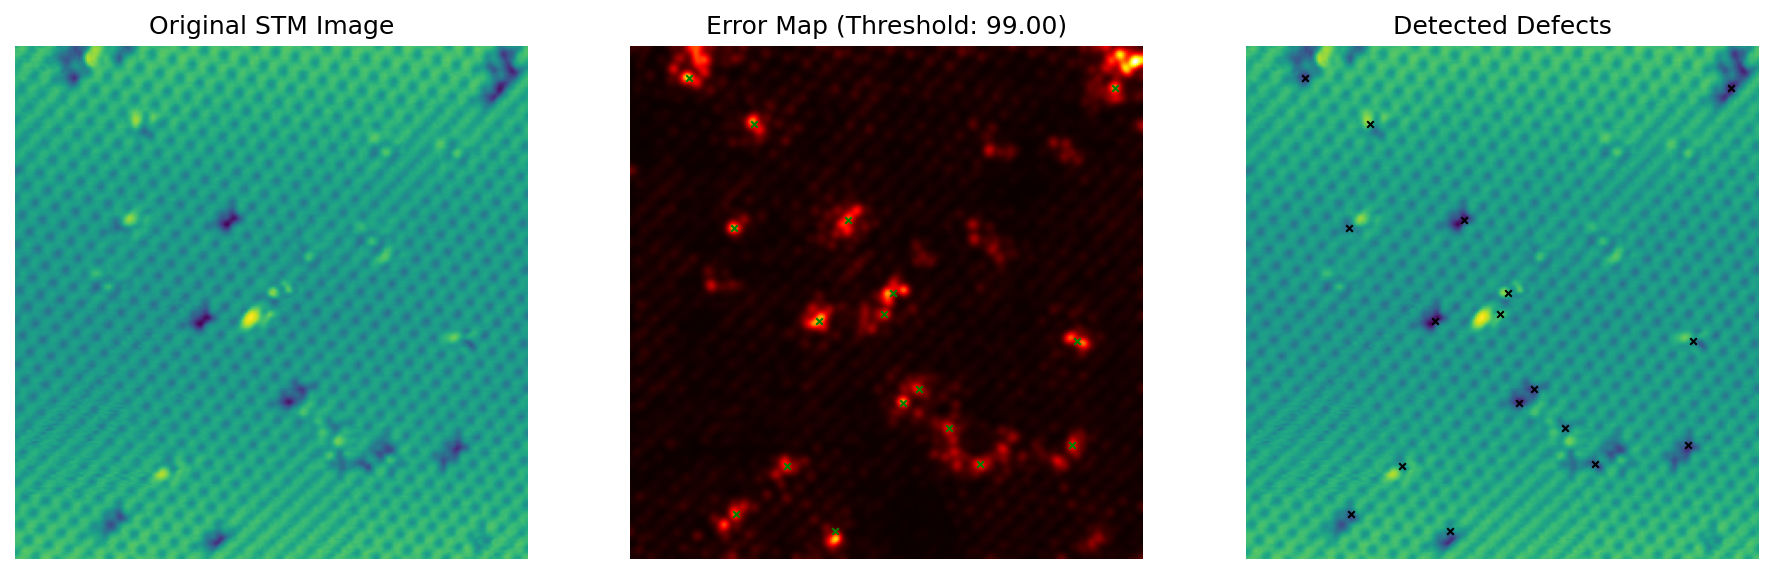

In [ ]:
image = (data[(data['Type'] == 'Predict')].iloc[7]['Image'])
    
char_map = mode_image(image, encoder_split, kmeansall, scaler, stride=4)
interactive_compareimage(image, char_map)

error_map, defect_patches, defect_centers = extract_high_error_patches(image, model, stride=24, plot_maps=True)

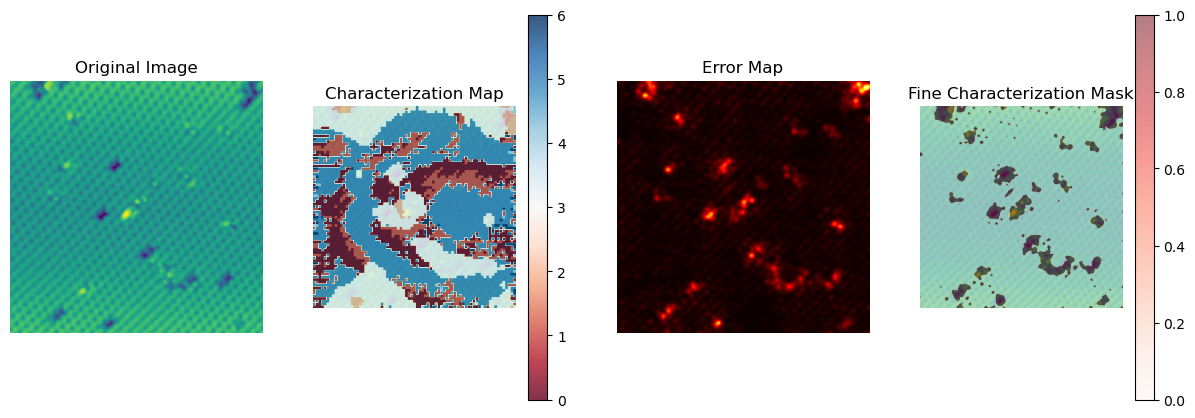

Number of regions detected: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


c:\Users\jaydi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


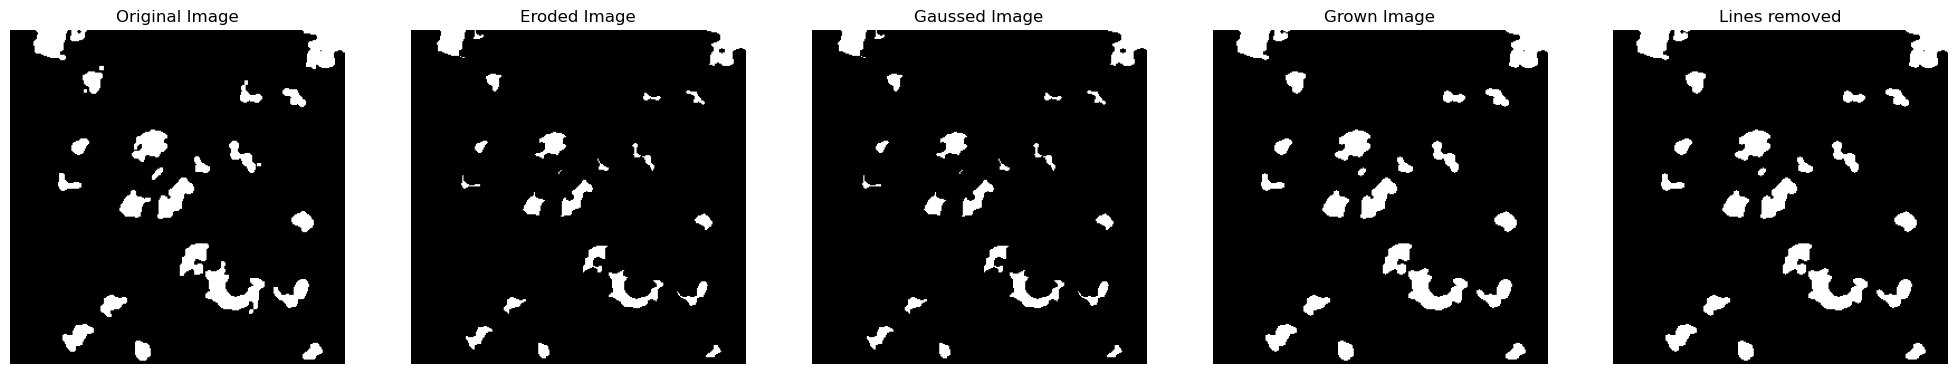

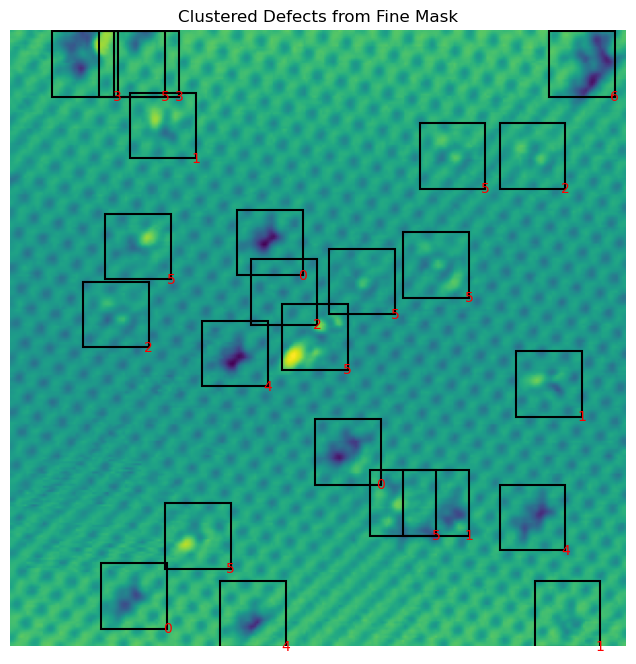

Plotting


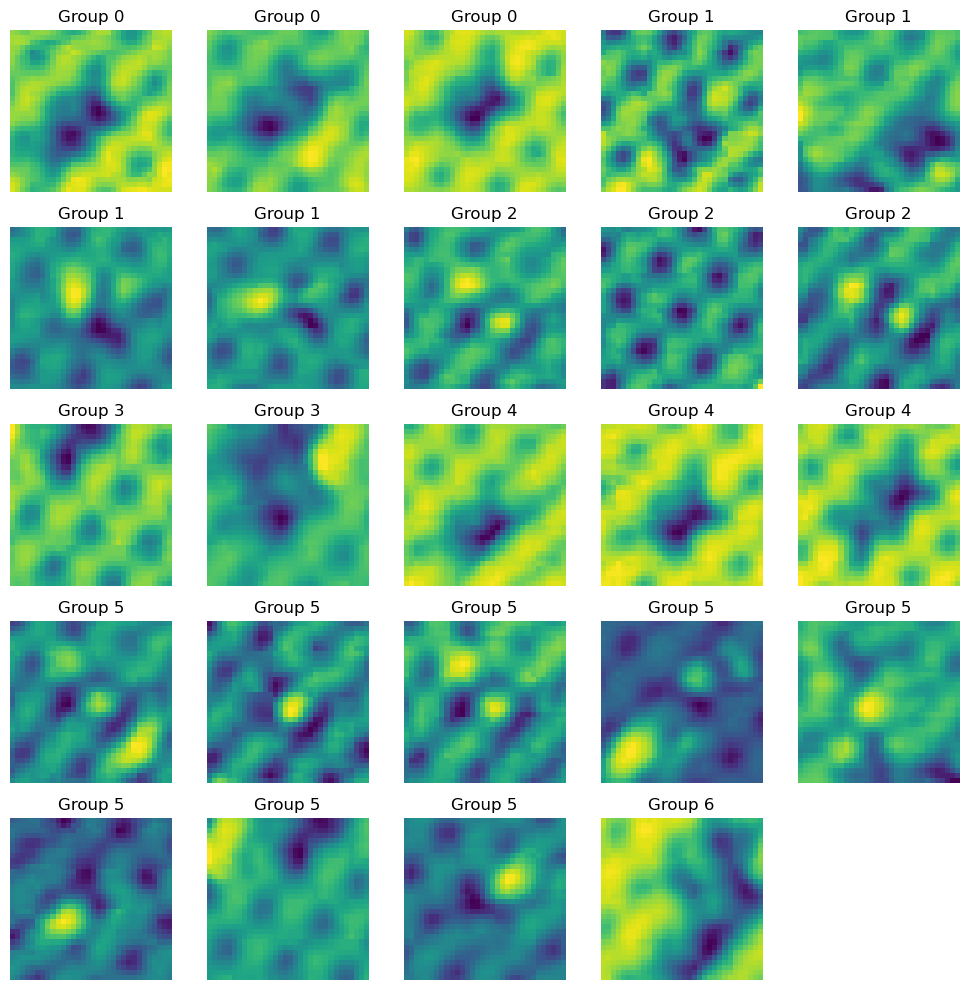

In [42]:
fine_map = generate_fine_characterization_mask(image, char_map, error_map, defect_centers, plot_mask=True, error_percentile=90)

cleaned_mask = clean_defect_mask(fine_map, min_area=60)

eroded_mask = clean_and_round_blobs(
    cleaned_mask,
    shrink_iterations=1,
    grow_iterations=1,
    kernel_size=5,
    line_threshold=2,
    sigma=0.1)

cluster_labels, filtered_patches, filtered_centers = extract_masked_patches_and_cluster(
    image, eroded_mask, encoder_split, kmeansall, scaler, min_dist=16, plot_overlay=True, plot_defects=True)

In [ ]:
for idx, val in enumerate(data['Image']):
    image = val
    image_id = idx
    print(idx, image.shape)
    if image.shape < (32,32):
        continue
    # Step 1: Generate character map and reconstruction error map
    char_map = mode_image(image, encoder_split, kmeansall, stride=8)
    error_map, defect_patches, defect_centers = extract_high_error_patches(
        image, model, stride=30, plot_maps=False)

    # Step 2: Generate and clean defect mask
    fine_map = generate_fine_characterization_mask(
        image, char_map, error_map, defect_centers, plot_mask=False, error_percentile=90)

    cleaned_mask = clean_defect_mask(fine_map, min_area=50)
    eroded_mask = clean_and_round_blobs(
        cleaned_mask,
        shrink_iterations=1,
        grow_iterations=1,
        kernel_size=5,
        line_threshold=2,
        sigma=0.1,
        plot_mask=False
    )

    # Step 3: Extract encoded defect patches and cluster
    cluster_labels, filtered_patches, filtered_centers = extract_masked_patches_and_cluster(
        image, eroded_mask, encoder_split, kmeansall, scaler, min_dist=16, plot_overlay=False, plot_defects=False)

    # Step 4: Store outputs
    all_defect_patches.extend(filtered_patches)
    print(len(all_defect_patches))

In [ ]:
all_defects_array=None
def filter_and_normalise_patches_chunked(memmap_array, batch_size=1000, threshold=0.05):
    """
    Process large .npy array in chunks: filter patches by zero-pixel ratio
    and normalise each patch to [0, 1] range.

    Parameters:
    - memmap_array: memory-mapped array of shape (N, 32, 32)
    - batch_size: number of patches to load per chunk
    - threshold: max proportion of zero pixels allowed

    Returns:
    - filtered_normalised_patches: numpy array of shape (?, 32, 32)
    """
    N = memmap_array.shape[0]
    results = []

    for i in tqdm(range(0, N, batch_size)):
        batch = memmap_array[i:i+batch_size]

        # Compute zero fraction
        zero_pixel_fraction = np.sum(batch == 0, axis=(1, 2)) / (32 * 32)
        valid_mask = zero_pixel_fraction < threshold

        # Filter valid patches
        valid_patches = batch[valid_mask]

        # Normalise each patch individually to [0, 1]
        min_vals = valid_patches.reshape(valid_patches.shape[0], -1).min(axis=1, keepdims=True)
        max_vals = valid_patches.reshape(valid_patches.shape[0], -1).max(axis=1, keepdims=True)
        ranges = max_vals - min_vals + 1e-8  # prevent division by zero

        normalised = ((valid_patches.reshape(valid_patches.shape[0], -1) - min_vals) / ranges).reshape(-1, 32, 32)

        results.append(normalised)

    return np.concatenate(results, axis=0)

# Example usage
filename = 'defect_patches_unknown.npy'
patches_memmap = np.load(filename, mmap_mode='r')
all_defects_array = filter_and_normalise_patches_chunked(patches_memmap, batch_size=1000)

print(all_defects_array.shape)

100%|██████████| 505/505 [01:04<00:00,  7.84it/s]


(444080, 32, 32)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


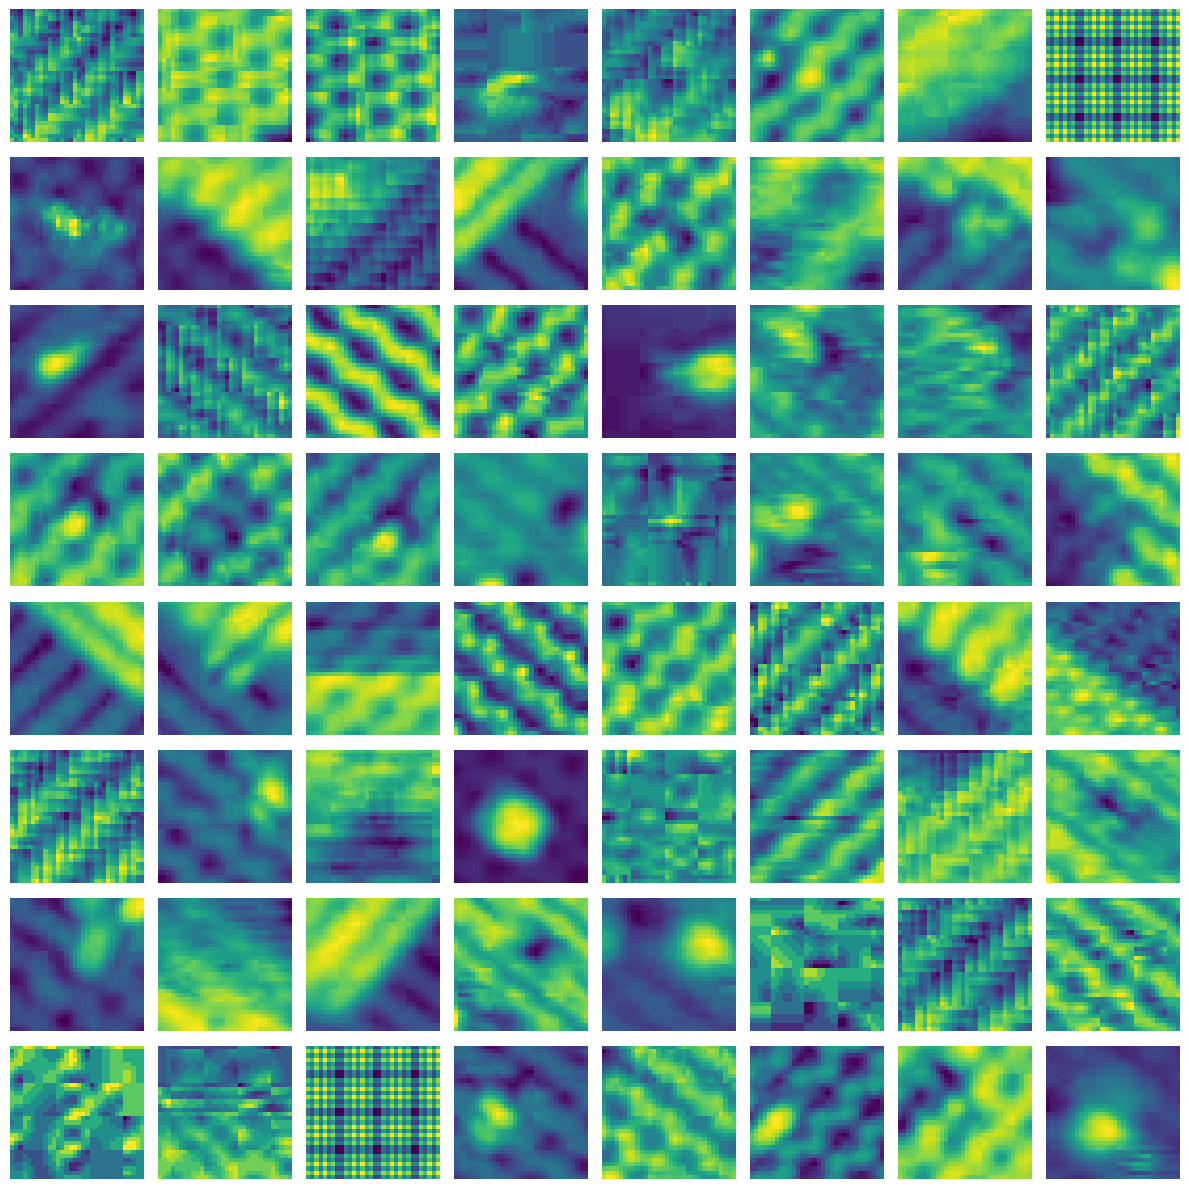

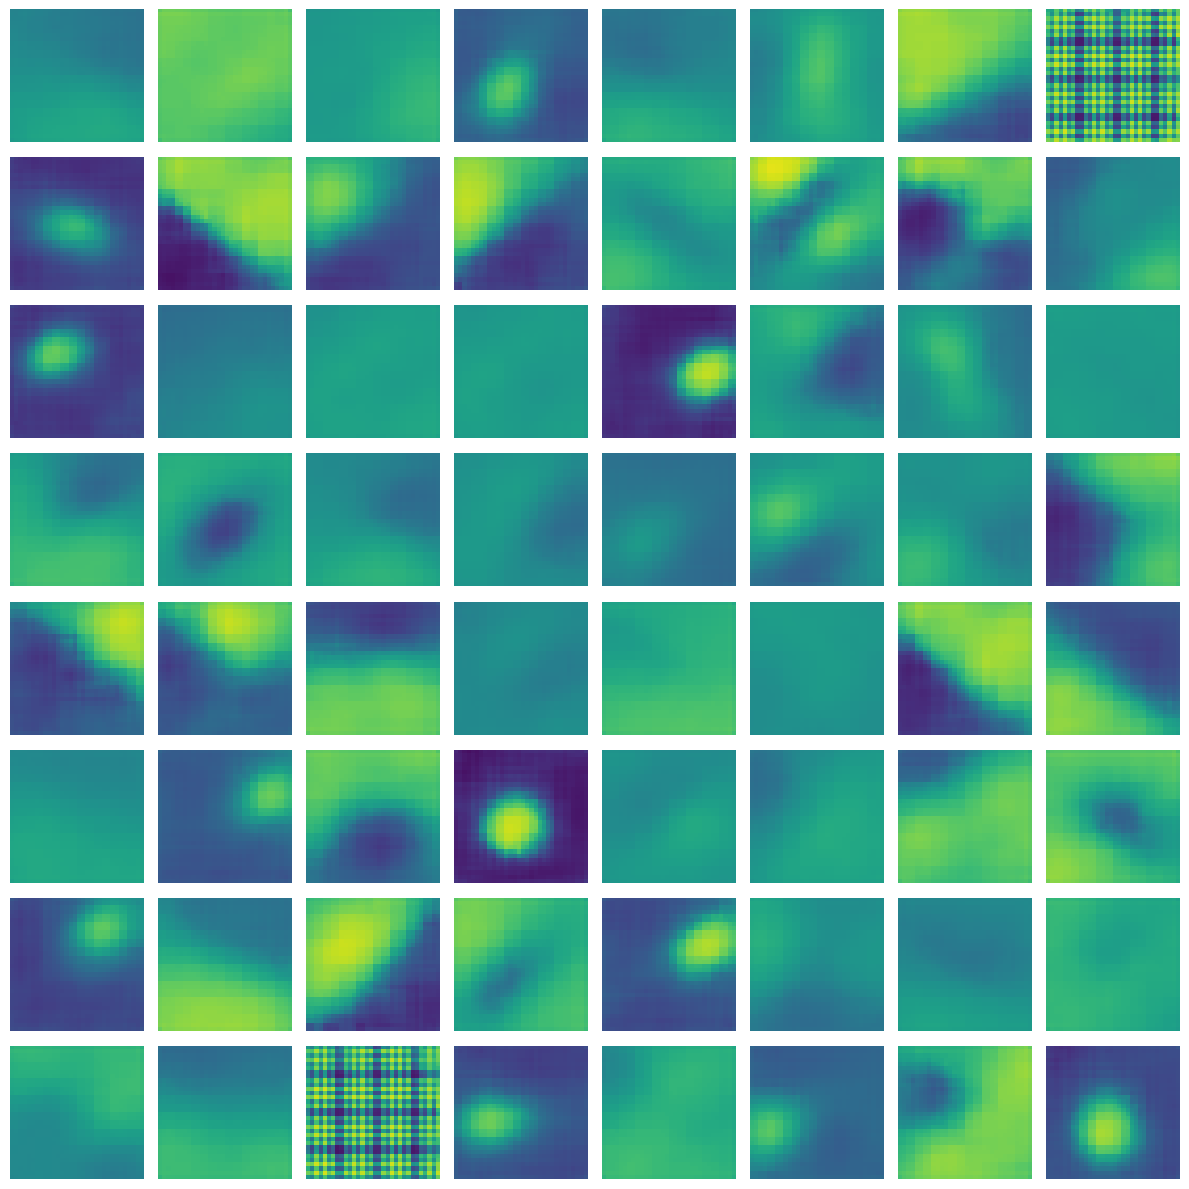

In [26]:
num_patches = len(all_defects_array)
sample_indices = np.random.choice(num_patches, size=min(64, num_patches), replace=False)

vis_sample = all_defects_array[sample_indices]

# Sample
sampled_patches = vis_sample
recon_sample = defectmodel.predict(vis_sample)

# Grid size (closest square)
grid_size = int(np.ceil(np.sqrt(len(sampled_patches))))

# Plot
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 1.5, grid_size * 1.5))
axes = axes.flatten()

for i, patch in enumerate(sampled_patches):
    axes[i].imshow(patch, cmap='viridis', vmin=0, vmax=1)
    axes[i].axis('off')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 1.5, grid_size * 1.5))
axes = axes.flatten()

for i, patch in enumerate(recon_sample):
    axes[i].imshow(patch, cmap='viridis', vmin=0, vmax=1)
    axes[i].axis('off')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(f'Training loss 8: ',modelhistory.history['loss'][-1])
print(f'Validation loss 8: ', modelhistory.history['val_loss'][-1])

laptopdefAE.save('Densemodel/finaltest/defectlaptoptrained.keras')

plt.plot(modelhistory.history['loss'], label='Training')
plt.plot(modelhistory.history['val_loss'], label='Testing')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Defect AE Training loss and Validation loss. 8 latent neurons')
plt.show()
plt.savefig('laptoptraineddefAE.png')
plt.clf()

In [ ]:


lap_def_encoder_split = keras.Model(inputs=laptopdefAE.input, outputs=laptopdefAE.get_layer('dense_21').output)

defect_ae_latent = lap_def_encoder_split.predict(defect_patches_n)
print(defect_ae_latent.shape)
defscaler = MinMaxScaler()
defect_ae_latent = defscaler.fit_transform(defect_ae_latent)

0it [00:00, ?it/s]

14681it [00:00, 29508.26it/s]


459/459 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step
(14681, 8)


In [27]:
defect_sample = None

N = all_defects_array.shape[0]
sample_indices = np.random.choice(N, size=100000, replace=False)
defect_sample = all_defects_array[sample_indices]

defect_ae_latent = def_encoder_split.predict(defect_sample)
print(defect_ae_latent.shape)
defscaler = MinMaxScaler()
defect_ae_latent_s = defscaler.fit_transform(defect_ae_latent)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 86s 27ms/step
(100000, 8)


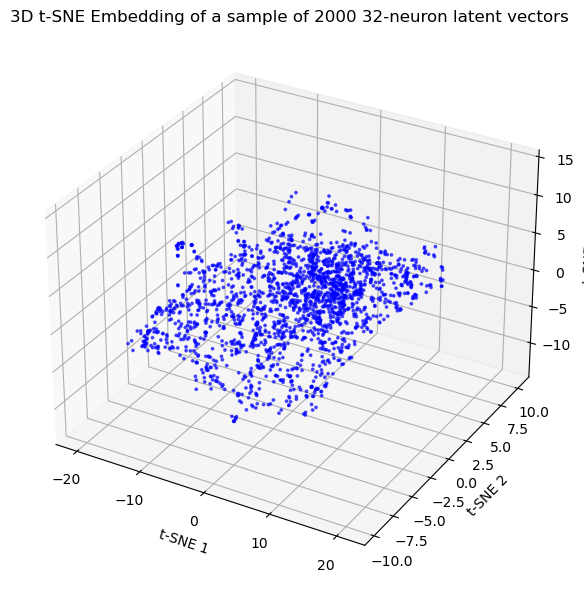

In [28]:
from sklearn.manifold import TSNE

# Sample a subset to make t-SNE computationally feasible
np.random.seed(42)
sample_indices = np.random.choice(defect_ae_latent_s.shape[0], size=2000, replace=False)
sampled_vectors = defect_ae_latent_s[sample_indices]

# Run t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=2000, init='random', random_state=42)
embedded = tsne.fit_transform(sampled_vectors)

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedded[:, 0], embedded[:, 1], embedded[:, 2],
           c='blue', s=3, alpha=0.6)

ax.set_title('3D t-SNE Embedding of a sample of 2000 32-neuron latent vectors')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
plt.tight_layout()
plt.show()

In [16]:
def compare_reconstruction(autoencoder, patch, cmap='viridis'):
    """
    Displays original and reconstructed image side by side using the given autoencoder.
    Assumes patch shape is (32, 32) or (32, 32, 1).
    """
    # Ensure shape is (1, 32, 32, 1)
    patch = np.array(patch, dtype=np.float32)
    if patch.ndim == 2:
        patch = np.expand_dims(patch, axis=-1)
    patch = np.expand_dims(patch, axis=0)

    # Normalize if necessary
    if patch.max() > 1.0:
        patch /= 255.0

    # Predict
    reconstructed = autoencoder.predict(patch)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(patch[0, :, :, 0], cmap=cmap)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(reconstructed[0, :, :, 0], cmap=cmap)
    axes[1].set_title("Reconstruction")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

(15000, 8)


Tuning eps: 100%|██████████| 20/20 [16:15<00:00, 48.78s/it]


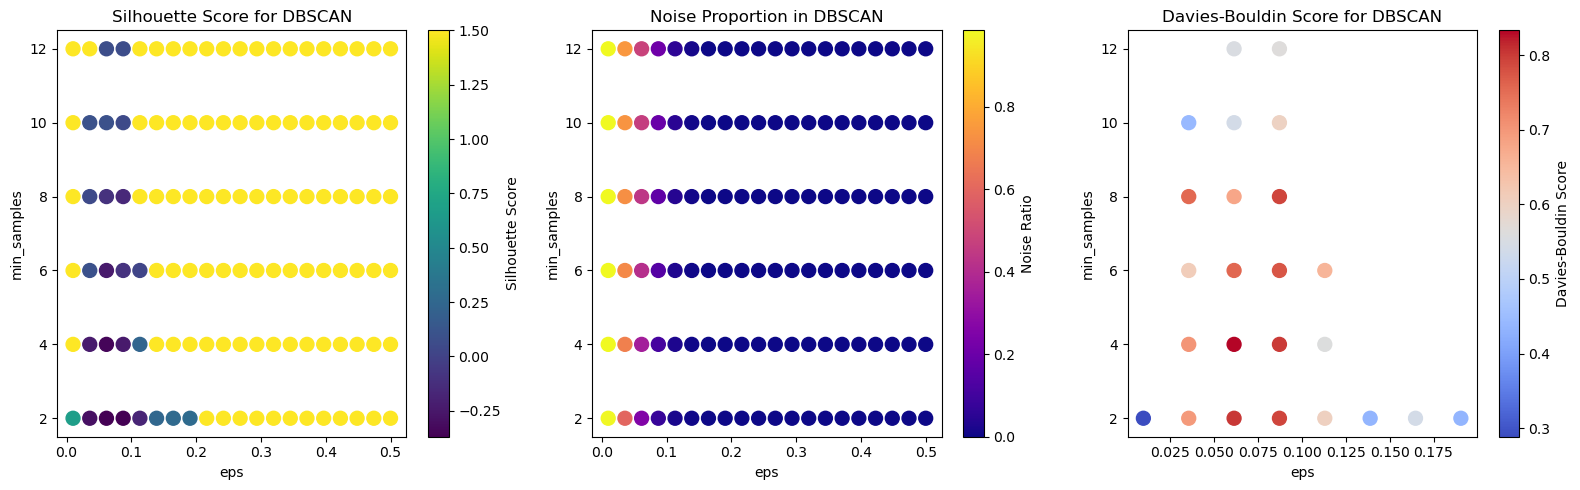

Best parameters: eps = 0.19052631578947368, min_samples = 2.0


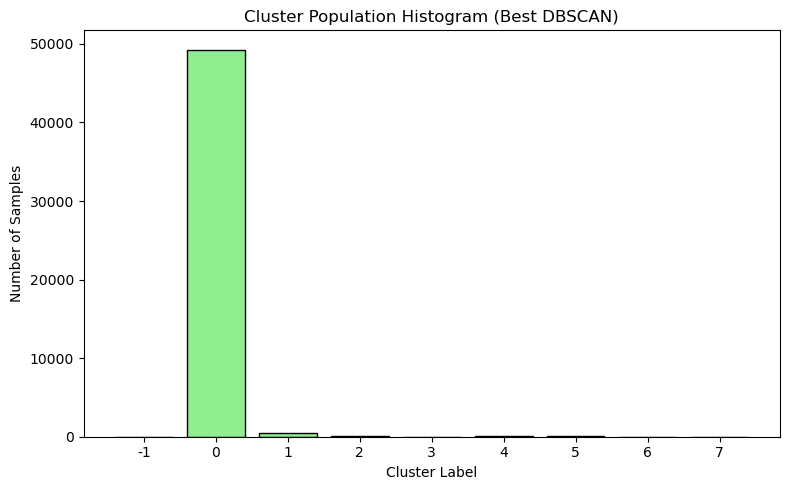

In [29]:
# Parameter grids
eps_range = np.linspace(0.01, 0.5, 20)
min_samples_range = range(2, 14, 2)

# Store metrics
silhouette_scores = []
db_scores = []
noise_ratios = []

test_sample = defect_ae_latent_s[0:15000]
print(test_sample.shape)
# Grid search over parameters
for eps in tqdm(eps_range, desc="Tuning eps"):
    for min_samples in tqdm(min_samples_range):
        dbscan = None
        labels = None
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        labels = dbscan.fit_predict(test_sample)
        
        # Exclude noise points
        core_samples_mask = (labels != -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)
        
        # Compute clustering metrics if there are at least 2 clusters
        if n_clusters > 7:
            sil_score = silhouette_score(test_sample[core_samples_mask], labels[core_samples_mask])
            db_score = davies_bouldin_score(test_sample[core_samples_mask], labels[core_samples_mask])
        else:
            sil_score = 1.5  # Invalid silhouette if only 1 cluster
            db_score = np.inf  # Invalid DB score if only 1 cluster
        
        # Store
        silhouette_scores.append((eps, min_samples, sil_score))
        db_scores.append((eps, min_samples, db_score))
        noise_ratios.append((eps, min_samples, noise_ratio))

# Convert to numpy arrays for easier handling
silhouette_array = np.array(silhouette_scores)
db_array = np.array(db_scores)
noise_array = np.array(noise_ratios)

# Plot Silhouette scores
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.scatter(silhouette_array[:, 0], silhouette_array[:, 1], c=silhouette_array[:, 2], cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Silhouette Score for DBSCAN')

# Plot Noise Ratios
plt.subplot(1, 3, 2)
plt.scatter(noise_array[:, 0], noise_array[:, 1], c=noise_array[:, 2], cmap='plasma', s=100)
plt.colorbar(label='Noise Ratio')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Noise Proportion in DBSCAN')

plt.subplot(1, 3, 3)
plt.scatter(db_array[:, 0], db_array[:, 1], c=db_array[:, 2], cmap='coolwarm', s=100)
plt.colorbar(label='Davies-Bouldin Score')
plt.xlabel('eps')
plt.ylabel('min_samples')
plt.title('Davies-Bouldin Score for DBSCAN')
plt.tight_layout()
plt.show()


# Step 1: Filter valid results
valid_mask = (silhouette_array[:, 2] < 1.5) & (db_array[:, 2] != np.inf)
valid_sil = silhouette_array[valid_mask]
valid_db = db_array[valid_mask]
valid_noise = noise_array[valid_mask]

# Step 2: Normalise (optional)
# Flip silhouette so higher is better => lower rank is better
sil_norm = -valid_sil[:, 2]
db_norm = valid_db[:, 2]
noise_norm = valid_noise[:, 2]

# Step 3: Rank
sil_rank = sil_norm.argsort().argsort()
db_rank = db_norm.argsort().argsort()
noise_rank = noise_norm.argsort().argsort()

# Step 4: Aggregate rank (equal weight)
total_rank = sil_rank + db_rank + noise_rank
best_idx = np.argmin(total_rank)

# Step 5: Retrieve best parameters
best_eps, best_min_samples = valid_sil[best_idx, 0], valid_sil[best_idx, 1]
print(f"Best parameters: eps = {best_eps}, min_samples = {best_min_samples}")

final_dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples), metric='euclidean')
final_labels = final_dbscan.fit_predict(defect_ae_latent_s[0:50000])

# Plot cluster histogram
unique_labels, counts = np.unique(final_labels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([str(int(lbl)) for lbl in unique_labels], counts, color='lightgreen', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Cluster Population Histogram (Best DBSCAN)')
plt.tight_layout()
plt.show()

Tuning HDBSCAN: 100%|██████████| 13/13 [07:47<00:00, 35.99s/it]


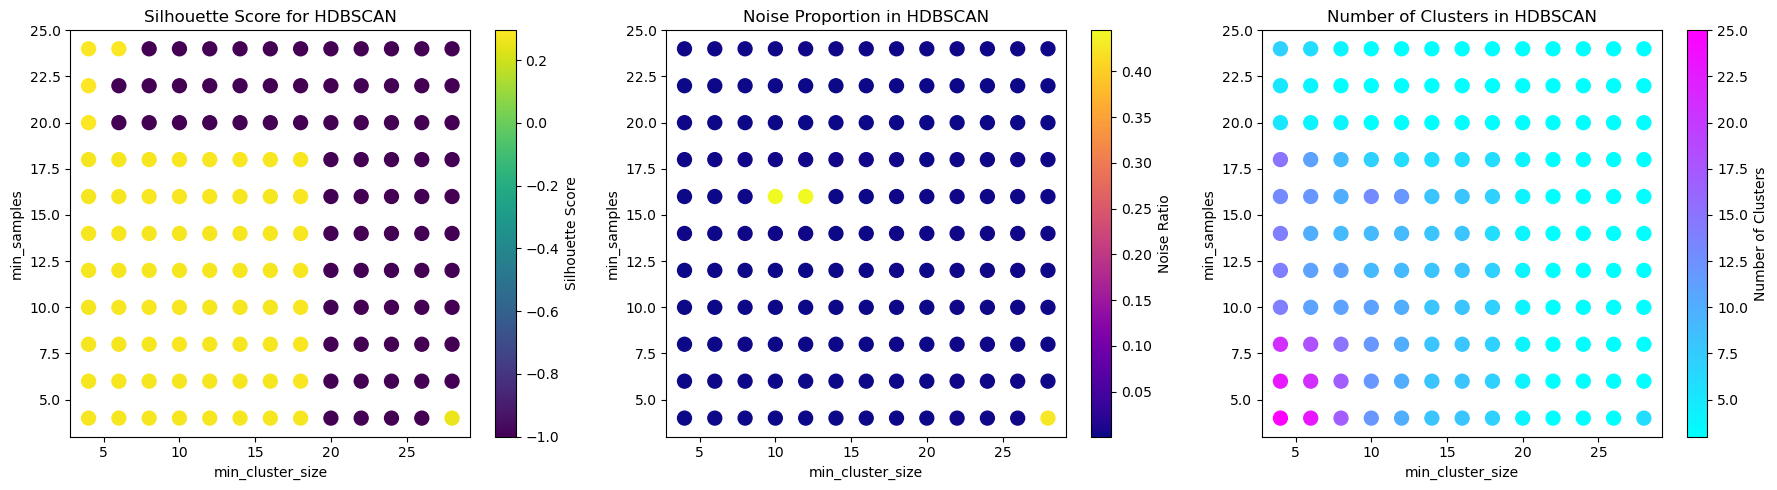

Best parameters: min_cluster_size = 4, min_samples = 24


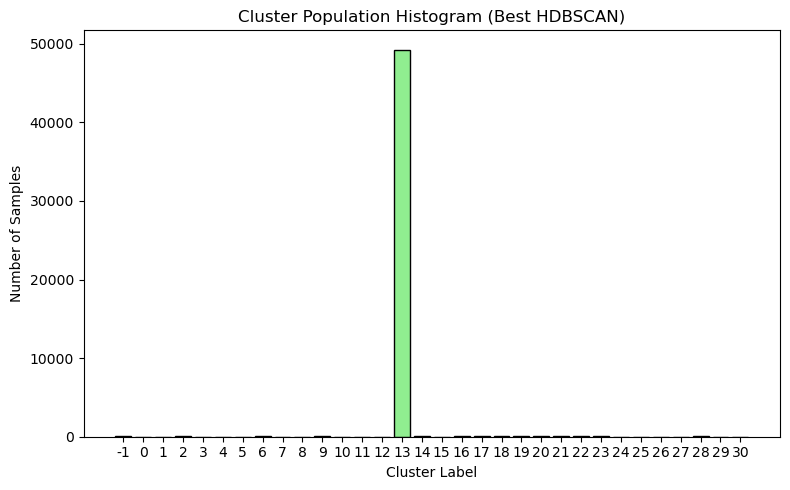

In [30]:
# Parameter grids
min_cluster_range = range(4, 30, 2)
min_samples_range = range(4, 26, 2)

# Store metrics
silhouette_scores = []
db_scores = []
noise_ratios = []
cluster_counts = []

# Sampling 10,000 points for tuning
#test_sample = defect_ae_latent_s[0:20000]

# Grid search over parameters
for min_cluster in tqdm(min_cluster_range, desc="Tuning HDBSCAN"):
    for min_samples in min_samples_range:
        hdb = HDBSCAN(min_cluster_size=min_cluster, min_samples=min_samples, metric='euclidean')
        labels = hdb.fit_predict(test_sample)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = np.sum(labels == -1) / len(labels)

        if n_clusters > 4:
            mask = labels != -1
            sil_score = silhouette_score(test_sample[mask], labels[mask])
            db_score = davies_bouldin_score(test_sample[mask], labels[mask])
        else:
            sil_score = -1
            db_score = np.inf

        silhouette_scores.append((min_cluster, min_samples, sil_score))
        db_scores.append((min_cluster, min_samples, db_score))
        noise_ratios.append((min_cluster, min_samples, noise_ratio))
        cluster_counts.append((min_cluster, min_samples, n_clusters))

# Convert to arrays
silhouette_array = np.array(silhouette_scores)
db_array = np.array(db_scores)
noise_array = np.array(noise_ratios)
cluster_count_array = np.array(cluster_counts)

# ---------------------- Visualisation ---------------------- #

plt.figure(figsize=(18, 5))

# Silhouette
plt.subplot(1, 3, 1)
plt.scatter(silhouette_array[:, 0], silhouette_array[:, 1], c=silhouette_array[:, 2], cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('min_cluster_size')
plt.ylabel('min_samples')
plt.title('Silhouette Score for HDBSCAN')

# Noise Ratio
plt.subplot(1, 3, 2)
plt.scatter(noise_array[:, 0], noise_array[:, 1], c=noise_array[:, 2], cmap='plasma', s=100)
plt.colorbar(label='Noise Ratio')
plt.xlabel('min_cluster_size')
plt.ylabel('min_samples')
plt.title('Noise Proportion in HDBSCAN')

# Cluster Count
plt.subplot(1, 3, 3)
plt.scatter(cluster_count_array[:, 0], cluster_count_array[:, 1], c=cluster_count_array[:, 2], cmap='cool', s=100)
plt.colorbar(label='Number of Clusters')
plt.xlabel('min_cluster_size')
plt.ylabel('min_samples')
plt.title('Number of Clusters in HDBSCAN')

plt.tight_layout()
plt.show()

# ---------------------- Ranking Strategy ---------------------- #

# Filter valid entries
valid_mask = (silhouette_array[:, 2] < 1.5) & (db_array[:, 2] != np.inf)
valid_sil = silhouette_array[valid_mask]
valid_db = db_array[valid_mask]
valid_noise = noise_array[valid_mask]

# Normalise (inverse ranking: lower is better)
sil_norm = -valid_sil[:, 2]
db_norm = valid_db[:, 2]
noise_norm = valid_noise[:, 2]

# Ranking
sil_rank = sil_norm.argsort().argsort()
db_rank = db_norm.argsort().argsort()
noise_rank = noise_norm.argsort().argsort()

# Aggregate
total_rank = sil_rank + db_rank + noise_rank
best_idx = np.argmin(total_rank)

# Best parameters
best_min_cluster = int(valid_sil[best_idx, 0])
best_min_samples = int(valid_sil[best_idx, 1])
print(f"Best parameters: min_cluster_size = {best_min_cluster}, min_samples = {best_min_samples}")

# ---------------------- Final HDBSCAN ---------------------- #

final_hdbscan = HDBSCAN(min_cluster_size=best_min_cluster, min_samples=best_min_samples, metric='euclidean')
final_labels = final_hdbscan.fit_predict(defect_ae_latent_s[0:50000])

# Plot cluster histogram
unique_labels, counts = np.unique(final_labels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([str(int(lbl)) for lbl in unique_labels], counts, color='lightgreen', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Cluster Population Histogram (Best HDBSCAN)')
plt.tight_layout()
plt.show()

GMM | cov=full: 100%|██████████| 12/12 [01:12<00:00,  6.05s/it]
GMM | cov=tied: 100%|██████████| 12/12 [00:58<00:00,  4.84s/it]
GMM | cov=diag: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]
GMM | cov=spherical: 100%|██████████| 12/12 [00:48<00:00,  4.08s/it]


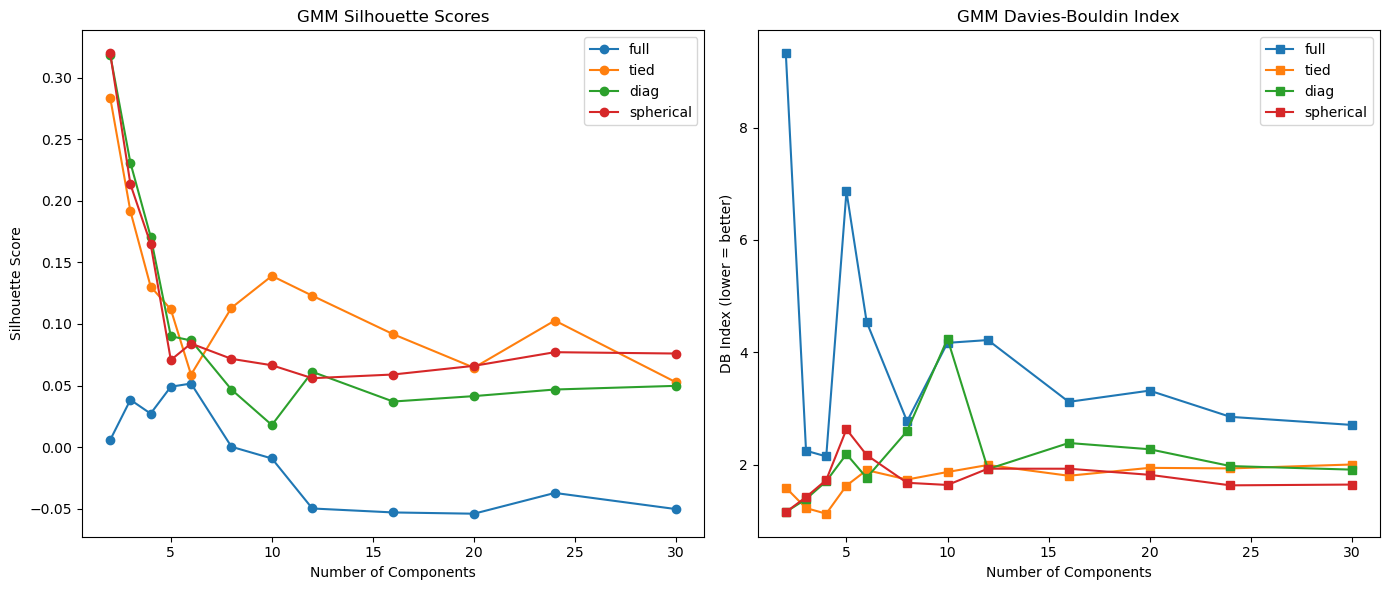

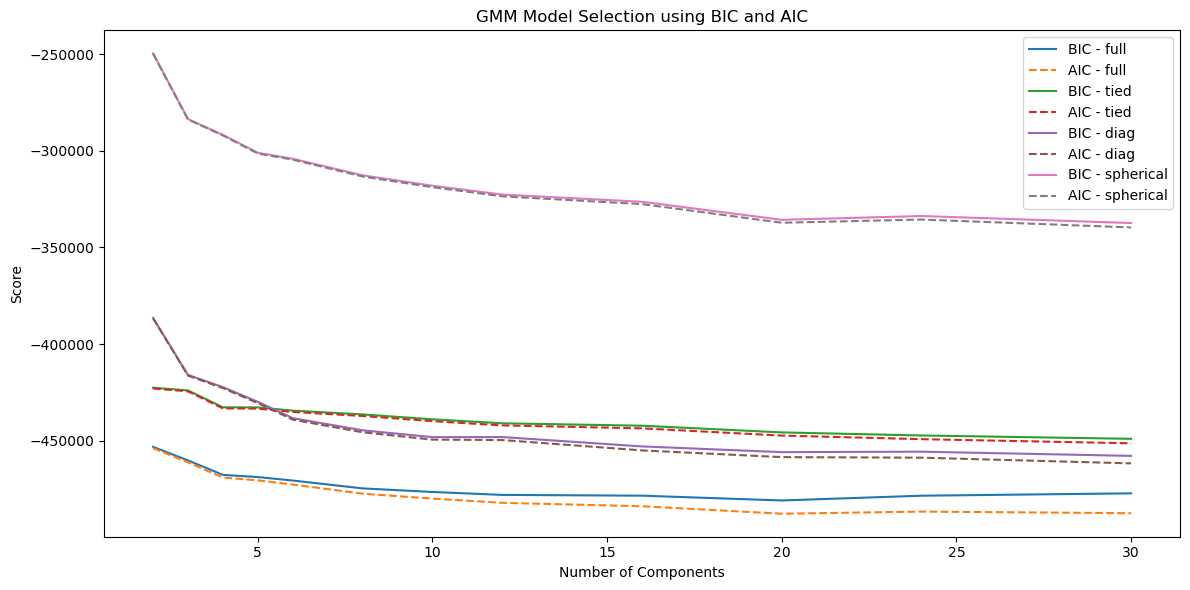

✅ Best GMM: k=20, cov=full, silhouette=-0.054, DBI=3.317, BIC=-480943.0


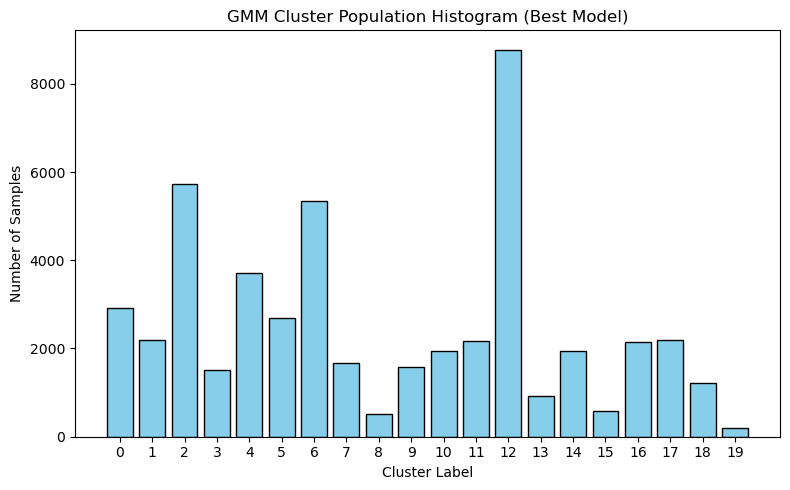

In [31]:
X = test_sample  # Use a manageable subset

n_components_range = [2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 30]
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_results = []

# Evaluate GMMs
for cov_type in covariance_types:
    for k in tqdm(n_components_range, desc=f"GMM | cov={cov_type}"):
        try:
            gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42)
            labels = gmm.fit_predict(X)
            sil = silhouette_score(X, labels)
            dbi = davies_bouldin_score(X, labels)
            bic = gmm.bic(X)
            aic = gmm.aic(X)

            gmm_results.append({
                'k': k,
                'cov': cov_type,
                'silhouette': sil,
                'dbi': dbi,
                'bic': bic,
                'aic': aic,
                'model': gmm
            })
        except Exception as e:
            print(f"Skipped k={k}, cov={cov_type}: {e}")

# ---------------------- Plot Silhouette & DBI ---------------------- #
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for cov_type in covariance_types:
    ks = [res['k'] for res in gmm_results if res['cov'] == cov_type]
    sils = [res['silhouette'] for res in gmm_results if res['cov'] == cov_type]
    dbs = [res['dbi'] for res in gmm_results if res['cov'] == cov_type]
    ax1.plot(ks, sils, label=cov_type, marker='o')
    ax2.plot(ks, dbs, label=cov_type, marker='s')

ax1.set_title('GMM Silhouette Scores')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Silhouette Score')
ax1.legend()

ax2.set_title('GMM Davies-Bouldin Index')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('DB Index (lower = better)')
ax2.legend()

plt.tight_layout()
plt.savefig('results/gmm_silhouette_dbi.png')
plt.show()

# ---------------------- Plot BIC & AIC ---------------------- #
plt.figure(figsize=(12, 6))
for cov_type in covariance_types:
    ks = [res['k'] for res in gmm_results if res['cov'] == cov_type]
    bics = [res['bic'] for res in gmm_results if res['cov'] == cov_type]
    aics = [res['aic'] for res in gmm_results if res['cov'] == cov_type]
    plt.plot(ks, bics, label=f'BIC - {cov_type}')
    plt.plot(ks, aics, linestyle='--', label=f'AIC - {cov_type}')

plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('GMM Model Selection using BIC and AIC')
plt.legend()
plt.tight_layout()
plt.savefig('results/gmm_bic_aic_selection.png')
plt.show()

# ---------------------- Select Best Model ---------------------- #

# Filter valid models
valid_models = [r for r in gmm_results if r['silhouette'] < 1.5 and np.isfinite(r['dbi'])]

# Ranking system: low DBI, high Silhouette, low BIC
for r in valid_models:
    r['sil_rank'] = -r['silhouette']
    r['db_rank'] = r['dbi']
    r['bic_rank'] = r['bic']

# Normalise + Rank
sorted_models = sorted(valid_models, key=lambda r: r['sil_rank'] + r['db_rank'] + 0.5 * r['bic_rank'])  # 0.5 weight for complexity
best_model = sorted_models[0]
print(f"✅ Best GMM: k={best_model['k']}, cov={best_model['cov']}, silhouette={best_model['silhouette']:.3f}, DBI={best_model['dbi']:.3f}, BIC={best_model['bic']:.1f}")

# ---------------------- Final Fit & Visualisation ---------------------- #

final_gmm = best_model['model']
final_labels = final_gmm.predict(defect_ae_latent_s[0:50000])

# Plot cluster histogram
unique_labels, counts = np.unique(final_labels, return_counts=True)

plt.figure(figsize=(8, 5))
plt.bar([str(lbl) for lbl in unique_labels], counts, color='skyblue', edgecolor='black')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('GMM Cluster Population Histogram (Best Model)')
plt.tight_layout()
plt.savefig('results/gmm_best_cluster_histogram.png')
plt.show()


In [33]:
gmm = GaussianMixture(n_components=20, covariance_type='full', random_state=42)
gmm.fit_predict(defect_ae_latent_s)

array([19, 19,  8, ..., 11,  9, 14], dtype=int64)

Number of regions detected: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


c:\Users\jaydi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


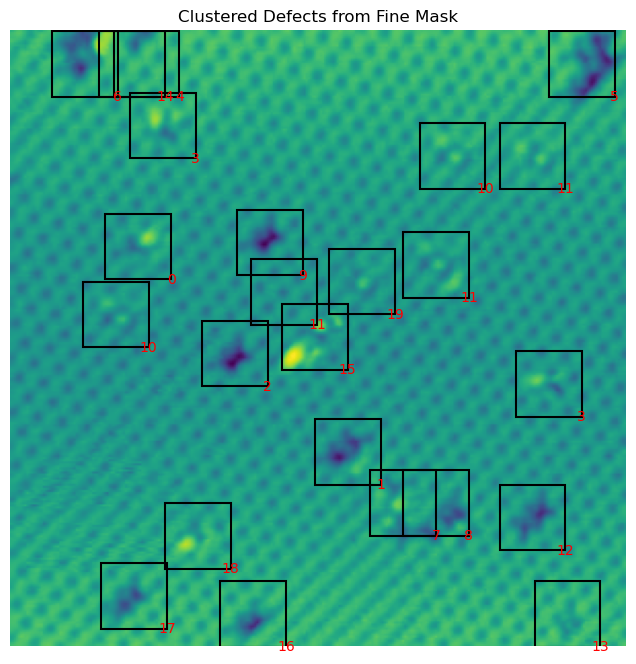

Plotting


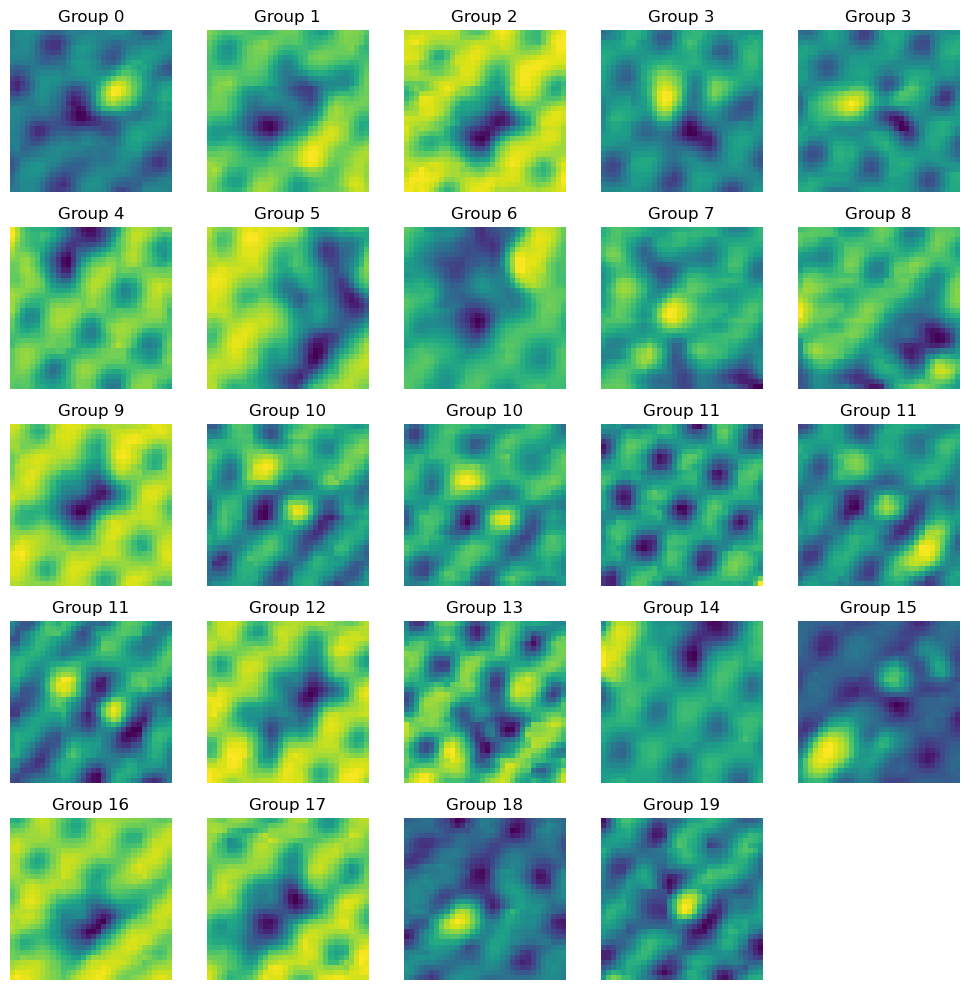

In [43]:
cluster_labels, filtered_patches, filtered_centers = extract_masked_patches_and_cluster(
    image, eroded_mask, def_encoder_split, gmm, defscaler, min_dist=16, plot_defects=True)

In [50]:
def_char_map = mode_image(image, def_encoder_split, gmm, defscaler, stride=2)
interactive_compareimage(image, def_char_map)

100%|██████████| 18225/18225 [05:14<00:00, 57.90it/s]


interactive(children=(Dropdown(description='selected_group', options=(None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, …